# YOLO Litter Detection - Part 1: YOLOv5 & YOLOv8 Models
## Replicating Bianco et al. Methodology on TACO-1 Dataset

This notebook is Part 1 of a comprehensive evaluation of YOLO models for litter detection, following the methodology from Bianco et al. "Efficient Deep Learning Models for Litter Detection in the Wild" (2024).

### Part 1 Coverage:
- **YOLOv5**: n, s, n6u, s6u variants
- **YOLOv8**: n, s variants
- Training on TACO-1 dataset for 100 epochs
- Confidence threshold optimization
- Inference speed benchmarking
- Results upload to GitHub repository

### Time Management:
- Optimized for <12 hour Kaggle limit
- Results saved and uploaded incrementally
- Designed to work with Part 2 notebook

## 1. Environment Setup and Dependencies

In [1]:
# Install required packages
!pip install ultralytics==8.3.161  # Latest stable
!pip install pandas matplotlib seaborn plotly
!pip install psutil GPUtil
!pip install tqdm
!pip install opencv-python-headless
!pip install GitPython

import os
import sys
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import YOLO and related libraries
from ultralytics import YOLO
import torch
import cv2
from PIL import Image
import git
from datetime import datetime

# Set up plotting parameters
plt.style.use('default')
sns.set_palette("husl")

print(f"🚀 YOLO Litter Detection - Part 1 Started")
print(f"📅 Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🎯 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🖥️  CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"💾 CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Create output directory
output_dir = Path('/kaggle/working/part1_results')
output_dir.mkdir(exist_ok=True)
print(f"📁 Output directory: {output_dir}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3

## 2. GitHub Repository Setup

In [2]:
# GitHub configuration - Update these with your repository details
GITHUB_CONFIG = {
    'username': 'GITHUB_USERNAME',  # Update with your GitHub username
    'repo_name': 'GITHUB_REPO',  # Update with your repo name
    'token': None,  # Will be set via Kaggle secrets
    'branch': 'main'
}

def setup_github_credentials():
    """Setup GitHub credentials from Kaggle secrets"""
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        github_token = user_secrets.get_secret("GitHub_key_yolo")
        github_username = user_secrets.get_secret("GITHUB_USERNAME")
        github_repo = user_secrets.get_secret("GITHUB_REPO")
        
        GITHUB_CONFIG['token'] = github_token
        GITHUB_CONFIG['username'] = github_username
        GITHUB_CONFIG['repo_name'] = github_repo
        
        print("✅ GitHub credentials loaded from Kaggle secrets")
        return True
    except Exception as e:
        print(f"⚠️  Could not load GitHub credentials: {e}")
        print("📝 Please set up Kaggle secrets with: GITHUB_TOKEN, GITHUB_USERNAME, GITHUB_REPO")
        return False

def upload_to_github(file_path, commit_message, folder_path="part1_results"):
    """Upload results to GitHub repository"""
    if not GITHUB_CONFIG['token']:
        print("❌ GitHub token not available. Skipping upload.")
        return False
    
    try:
        # Clone or update repository
        repo_url = f"https://{GITHUB_CONFIG['token']}@github.com/{GITHUB_CONFIG['username']}/{GITHUB_CONFIG['repo_name']}.git"
        local_repo_path = f"/kaggle/working/{GITHUB_CONFIG['repo_name']}"
        
        if not os.path.exists(local_repo_path):
            print(f"📥 Cloning repository...")
            repo = git.Repo.clone_from(repo_url, local_repo_path)
        else:
            print(f"🔄 Updating repository...")
            repo = git.Repo(local_repo_path)
            repo.remotes.origin.pull()
        
        # Create target directory
        target_dir = Path(local_repo_path) / folder_path
        target_dir.mkdir(parents=True, exist_ok=True)
        
        # Copy file to repository
        import shutil
        target_file = target_dir / Path(file_path).name
        shutil.copy2(file_path, target_file)
        
        # Commit and push
        repo.index.add([str(target_file.relative_to(local_repo_path))])
        repo.index.commit(commit_message)
        repo.remotes.origin.push()
        
        print(f"✅ Uploaded {Path(file_path).name} to GitHub")
        return True
        
    except Exception as e:
        print(f"❌ Failed to upload to GitHub: {e}")
        return False

# Setup GitHub credentials
github_available = setup_github_credentials()
print(f"🔗 GitHub integration: {'Enabled' if github_available else 'Disabled'}")

✅ GitHub credentials loaded from Kaggle secrets
🔗 GitHub integration: Enabled


## 3. Dataset Preparation - TACO Dataset

In [3]:
# convert COCO data to YOLO format
import json
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm

def convert_coco_to_yolo(coco_file, image_base_path, output_dir):
    """
    Convert COCO annotations to YOLO format for single class 'litter'
    
    Args:
        coco_file: Path to COCO annotations JSON file
        image_base_path: Base path containing batch directories with images
        output_dir: Output directory for YOLO format files
    """
    
    # Load COCO data
    with open(coco_file, 'r') as f:
        coco_data = json.load(f)
    
    # Create output directories
    output_path = Path(output_dir)
    labels_dir = output_path / 'labels'
    images_dir = output_path / 'images'
    
    labels_dir.mkdir(parents=True, exist_ok=True)
    images_dir.mkdir(parents=True, exist_ok=True)
    
    # Create image info lookup
    image_info = {img['id']: img for img in coco_data['images']}
    
    # Group annotations by image_id
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        annotations_by_image[img_id].append(ann)
    
    # Process each image with progress bar
    processed_count = 0
    name_counter = {}  # Track filename usage for unique naming
    
    for img_id, img_data in tqdm(image_info.items(), desc="Converting images"):
        file_name = img_data['file_name']
        width = img_data['width']
        height = img_data['height']
        
        # Generate unique filename (flat structure)
        original_stem = Path(file_name).stem
        batch_folder = Path(file_name).parent.name  # Get batch folder name
        
        # Create unique name combining batch and original name
        unique_stem = f"{batch_folder}_{original_stem}"
        
        # Handle duplicates if they still exist
        if unique_stem in name_counter:
            name_counter[unique_stem] += 1
            unique_stem = f"{unique_stem}_{name_counter[unique_stem]}"
        else:
            name_counter[unique_stem] = 0
        
        # Create YOLO files with unique names (flat structure)
        label_filename = unique_stem + '.txt'
        label_path = labels_dir / label_filename
        
        image_filename = unique_stem + '.jpg'  # Always lowercase .jpg
        dest_image_path = images_dir / image_filename
        
        # Copy image with unique name
        source_image_path = Path(image_base_path) / file_name
        
        if source_image_path.exists():
            import shutil
            shutil.copy2(source_image_path, dest_image_path)
        else:
            print(f"Missing: {file_name}")
        
        # Convert annotations to YOLO format
        yolo_annotations = []
        
        if img_id in annotations_by_image:
            for ann in annotations_by_image[img_id]:
                # COCO bbox format: [x, y, width, height] (top-left corner)
                x, y, w, h = ann['bbox']
                
                # Convert to YOLO format: [class, x_center, y_center, width, height] (normalized)
                x_center = (x + w / 2) / width
                y_center = (y + h / 2) / height
                norm_width = w / width
                norm_height = h / height
                
                # Class 0 for 'litter' (single class)
                yolo_annotations.append(f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")
        
        # Write YOLO label file with unique filename
        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))
        
        processed_count += 1
    
    # Create classes.txt file
    classes_file = output_path / 'classes.txt'
    with open(classes_file, 'w') as f:
        f.write('litter\n')
    
    # Create data.yaml file for YOLO training
    yaml_content = f"""# TACO-1 Dataset YOLO Configuration
path: {output_path.absolute()}
train: images
val: images

# Classes
nc: 1
names: ['litter']
"""
    
    with open(output_path / 'data.yaml', 'w') as f:
        f.write(yaml_content)
    
    return processed_count

# Main execution
if __name__ == "__main__":
    # Paths
    coco_file = '/kaggle/input/taco-1/TACO-1 dataset/annotations_litter.json'
    image_base_path = '/kaggle/input/taco-1/TACO-1 dataset'
    output_dir = 'yolo_dataset'
    
    print("Converting COCO to YOLO format...")
    processed = convert_coco_to_yolo(coco_file, image_base_path, output_dir)
    
    print(f"\nConversion complete!")
    print(f"Processed {processed} images")
    print(f"Output directory: {output_dir}")
    print(f"Files created:")
    print(f"  - images/ (copied images)")
    print(f"  - labels/ (YOLO format annotations)")
    print(f"  - classes.txt (class names)")
    print(f"  - data.yaml (YOLO config)")
    
    print("\nReady for splitting the data!")

Converting COCO to YOLO format...


Converting images: 100%|██████████| 1500/1500 [00:48<00:00, 30.95it/s]


Conversion complete!
Processed 1500 images
Output directory: yolo_dataset
Files created:
  - images/ (copied images)
  - labels/ (YOLO format annotations)
  - classes.txt (class names)
  - data.yaml (YOLO config)

Ready for splitting the data!


In [4]:
# Split the dataset according to Bianco et al. paper: 70%-10%-20%
import os
import shutil
import random
from pathlib import Path
from sklearn.model_selection import train_test_split

def split_dataset(images_dir, labels_dir, output_dir, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2, random_state=42):
    """Split YOLO dataset into train/val/test"""
    print(f"📊 Splitting dataset: {train_ratio*100}% train, {val_ratio*100}% val, {test_ratio*100}% test")
    images_path = Path(images_dir)
    labels_path = Path(labels_dir)
    output_path = Path(output_dir)
    # Find all images
    image_files = list(images_path.glob('*.jpg'))
    print(f"Found {len(image_files)} images")
    # Match with labels (flat structure)
    valid_pairs = []
    for img in image_files:
        img_stem = img.stem
        label_file = labels_path / (img_stem + '.txt')
        if label_file.exists():
            valid_pairs.append(img.name)
        else:
            print(f"Missing label: {img_stem}.txt")
    print(f"Valid pairs: {len(valid_pairs)}")
    # Split data
    random.seed(random_state)
    random.shuffle(valid_pairs)
    train_val, test = train_test_split(valid_pairs, test_size=test_ratio, random_state=random_state)
    val_size = val_ratio / (train_ratio + val_ratio)
    train, val = train_test_split(train_val, test_size=val_size, random_state=random_state)
    # Create directories
    for split in ['train', 'val', 'test']:
        (output_path / split / 'images').mkdir(parents=True, exist_ok=True)
        (output_path / split / 'labels').mkdir(parents=True, exist_ok=True)
    # Copy files (flat structure)
    def copy_split(pairs, split_name):
        for pair in pairs:
            img_name = pair
            label_name = Path(pair).stem + '.txt'
            shutil.copy2(images_path / img_name, output_path / split_name / 'images' / img_name)
            shutil.copy2(labels_path / label_name, output_path / split_name / 'labels' / label_name)
    print("Copying files...")
    copy_split(train, 'train')
    copy_split(val, 'val')
    copy_split(test, 'test')
    # Create data.yaml
    yaml_content = f"""path: {output_path.absolute()}
train: train/images
val: val/images
test: test/images
nc: 1
names: ['litter']
# Split counts
total: {len(valid_pairs)}
train_count: {len(train)}
val_count: {len(val)}
test_count: {len(test)}
"""
    with open(output_path / 'data.yaml', 'w') as f:
        f.write(yaml_content)
    print(f"✅ Dataset split completed:")
    print(f"   📊 Train: {len(train)} images")
    print(f"   📊 Val: {len(val)} images")
    print(f"   📊 Test: {len(test)} images")
    return len(train), len(val), len(test)
if __name__ == "__main__":
    # Update paths to match your converted dataset
    images_dir = 'yolo_dataset/images'
    labels_dir = 'yolo_dataset/labels'
    output_dir = 'yolo_dataset_split'
    if os.path.exists(images_dir) and os.path.exists(labels_dir):
        split_dataset(images_dir, labels_dir, output_dir)
        print("Dataset ready for training!")
    else:
        print("Check directory paths")

📊 Splitting dataset: 70.0% train, 10.0% val, 20.0% test
Found 1500 images
Valid pairs: 1500
Copying files...
✅ Dataset split completed:
   📊 Train: 1049 images
   📊 Val: 151 images
   📊 Test: 300 images
Dataset ready for training!


## 4. Model Configuration - Part 1 Models

In [5]:
# Define Part 1 YOLO models (YOLOv5 & YOLOv8)
PART1_YOLO_MODELS = {
    # YOLOv5 variants
    'yolov5n': 'yolov5nu.pt',
    'yolov5s': 'yolov5su.pt',
    'yolov5n6u': 'yolov5n6u.pt',
    'yolov5s6u': 'yolov5s6u.pt',
    
    # YOLOv8 variants
    'yolov8n': 'yolov8n.pt',
    'yolov8s': 'yolov8s.pt',
}

# Training parameters from Bianco et al. paper
TRAINING_PARAMS = {
    'epochs': 100,
    'imgsz': 640,  # Default for most models (1280 for 6u variants)
    'batch': -1,   # Automatic batch size selection
    'optimizer': 'auto',  # Automatic optimizer selection
    'device': 0 if torch.cuda.is_available() else 'cpu',
    'workers': 8,
    'project': 'yolo_litter_detection_part1',
    'save_period': 10,
    'val': True,
    'plots': True,
    'verbose': True,
}

# Additional augmentation parameters from the paper Bianco et al.
AUGMENTATION_PARAMS = {
    'flipud': 0.5,      # Flip upside down probability
    'degrees': 10.0,    # Rotation range [-10, 10] degrees
    'copy_paste': 0.1,  # Copy paste augmentation probability
}

# Confidence threshold values for optimization (from paper)
CONFIDENCE_THRESHOLDS = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

print(f"🎯 Part 1 Models: {len(PART1_YOLO_MODELS)} YOLO models")
print(f"📋 Models: {', '.join(PART1_YOLO_MODELS.keys())}")
print(f"⚙️  Training: {TRAINING_PARAMS['epochs']} epochs, image size {TRAINING_PARAMS['imgsz']}")
print(f"🎚️  Confidence thresholds: {len(CONFIDENCE_THRESHOLDS)} values")

🎯 Part 1 Models: 6 YOLO models
📋 Models: yolov5n, yolov5s, yolov5n6u, yolov5s6u, yolov8n, yolov8s
⚙️  Training: 100 epochs, image size 640
🎚️  Confidence thresholds: 11 values


## 5. Training and Evaluation Functions

In [6]:
def save_intermediate_results(results, filename):
    """Save intermediate results and upload to GitHub"""
    filepath = Path(output_dir) / filename
    
    # Save as CSV
    df = pd.DataFrame(results)
    df.to_csv(filepath, index=False)
    
    # Save as JSON for detailed data
    json_filepath = filepath.with_suffix('.json')
    with open(json_filepath, 'w') as f:
        json.dump(results, f, indent=2, default=str)
    
    print(f"💾 Saved results to {filepath}")
    
    # Upload to GitHub
    if github_available:
        upload_to_github(filepath, f"Update Part 1 results: {filename}")
        upload_to_github(json_filepath, f"Update Part 1 detailed results: {json_filepath.name}")

def train_yolo_model(model_name, model_path, dataset_yaml, training_params, augmentation_params):
    """Train a single YOLO model following Bianco et al. methodology"""
    
    print(f"\n{'='*60}")
    print(f"🚀 Training {model_name}")
    print(f"{'='*60}")
    
    try:
        # Load model
        model = YOLO(model_path)
        
        # Adjust image size for 6u variants
        current_params = training_params.copy()
        if '6u' in model_name:
            current_params['imgsz'] = 1280
            print(f"📐 Using image size 1280 for {model_name}")
        
        # Set experiment name
        current_params['name'] = model_name
        
        # Combine training and augmentation parameters
        all_params = {**current_params, **augmentation_params}
        
        # Start training
        start_time = time.time()
        print(f"⏱️  Training started at {datetime.now().strftime('%H:%M:%S')}")
        
        results = model.train(
            data=dataset_yaml,
            **all_params
        )
        
        training_time = time.time() - start_time
        print(f"✅ Training completed in {training_time/3600:.2f} hours")
        
        return {
            'model_name': model_name,
            'model_path': model_path,
            'results': results,
            'training_time': training_time,
            'weights_path': f"yolo_litter_detection_part1/{model_name}/weights/best.pt"
        }
        
    except Exception as e:
        print(f"❌ Error training {model_name}: {str(e)}")
        return None

def get_model_info(model_path):
    """Get model information (size, parameters)"""
    try:
        model = YOLO(model_path)
        
        # Get model size in MB
        if os.path.exists(model_path):
            size_mb = os.path.getsize(model_path) / (1024 * 1024)
        else:
            # For pre-trained models, estimate size
            temp_model = YOLO(model_path)
            temp_model.save('/tmp/temp_model.pt')
            size_mb = os.path.getsize('/tmp/temp_model.pt') / (1024 * 1024)
            os.remove('/tmp/temp_model.pt')
        
        # Get number of parameters
        total_params = sum(p.numel() for p in model.model.parameters())
        
        return {
            'size_mb': size_mb,
            'parameters': total_params
        }
    except Exception as e:
        print(f"⚠️  Error getting model info: {str(e)}")
        return {'size_mb': 0, 'parameters': 0}

def benchmark_inference_speed(model_path, test_images_path, num_images=100, warmup_runs=10):
    """Benchmark inference speed following standard practices"""
    
    try:
        model = YOLO(model_path)
        
        # Get test images
        test_images = list(Path(test_images_path).glob('*.jpg'))[:num_images]
        
        if not test_images:
            print(f"⚠️  No test images found in {test_images_path}")
            return None
        
        # Warmup runs
        print(f"🔥 Warming up with {warmup_runs} runs...")
        for i in range(min(warmup_runs, len(test_images))):
            _ = model(str(test_images[i]), verbose=False)
        
        # Actual benchmark
        print(f"⚡ Benchmarking inference speed on {len(test_images)} images...")
        
        inference_times = []
        
        for img_path in tqdm(test_images, desc="Processing images"):
            start_time = time.time()
            _ = model(str(img_path), verbose=False)
            end_time = time.time()
            
            inference_times.append(end_time - start_time)
        
        # Calculate statistics
        avg_time = np.mean(inference_times)
        std_time = np.std(inference_times)
        fps = 1.0 / avg_time
        
        print(f"📊 Average inference time: {avg_time*1000:.2f}ms")
        print(f"📊 Inference speed: {fps:.1f} FPS")
        
        return {
            'avg_inference_time': avg_time,
            'std_inference_time': std_time,
            'fps': fps,
            'total_images': len(test_images)
        }
        
    except Exception as e:
        print(f"❌ Error benchmarking inference speed: {str(e)}")
        return None

def benchmark_yolo_inference(model_path, data_yaml):
    """Get inference speed from YOLO validation"""
    try:
        model = YOLO(model_path)
        results = model.val(data=data_yaml, verbose=False)
        
        if hasattr(results, 'speed') and results.speed:
            inference_ms = results.speed['inference']
            fps = 1000 / inference_ms if inference_ms > 0 else 0
        else:
            fps = 0
            inference_ms = 0
            
        return {
            'fps': fps,
            'avg_inference_time': inference_ms / 1000
        }
    except:
        return {'fps': 0, 'avg_inference_time': 0}

def optimize_confidence_threshold(model_path, val_dataset_yaml, confidence_thresholds):
    """Optimize confidence threshold following Bianco et al. methodology"""
    
    print(f"🎯 Optimizing confidence threshold for {Path(model_path).name}")
    
    try:
        model = YOLO(model_path)
        
        best_conf = 0.001
        best_map50 = 0.0
        confidence_results = []
        
        for conf in tqdm(confidence_thresholds, desc="Testing confidence thresholds"):
            # Validate with specific confidence threshold
            results = model.val(
                data=val_dataset_yaml,
                split='val',
                conf=conf,
                verbose=False
            )
            
            map50 = results.box.map50 if results.box.map50 is not None else 0.0
            map50_95 = results.box.map if results.box.map is not None else 0.0
            
            confidence_results.append({
                'confidence': conf,
                'mAP50': map50,
                'mAP50_95': map50_95
            })
            
            if map50 > best_map50:
                best_map50 = map50
                best_conf = conf
        
        print(f"🎯 Best confidence: {best_conf} (mAP50: {best_map50:.3f})")
        
        return {
            'best_confidence': best_conf,
            'best_map50': best_map50,
            'confidence_results': confidence_results
        }
        
    except Exception as e:
        print(f"❌ Error optimizing confidence threshold: {str(e)}")
        return None

def profile_model_performance(model_path, test_dataset_yaml, conf=0.001):
    """Profile model performance on test set"""
    
    try:
        model = YOLO(model_path)
        
        # Validate on test set
        results = model.val(
            data=test_dataset_yaml,
            split='test',
            conf=conf,
            verbose=False
        )
        
        return {
            'mAP50': results.box.map50 if results.box.map50 is not None else 0.0,
            'mAP50_95': results.box.map if results.box.map is not None else 0.0,
            'precision': results.box.mp if results.box.mp is not None else 0.0,
            'recall': results.box.mr if results.box.mr is not None else 0.0
        }
        
    except Exception as e:
        print(f"❌ Error profiling model performance: {str(e)}")
        return None

print("✅ All functions defined successfully")

✅ All functions defined successfully


## 6. Main Training Loop - Part 1

In [7]:
# Initialize results storage
part1_results = []
failed_models = []
start_time = time.time()
yaml_path = '/kaggle/working/yolo_dataset_split/data.yaml'

print(f"🚀 Starting Part 1 Training Loop")
print(f"📊 Models to train: {len(PART1_YOLO_MODELS)}")
print(f"⏰ Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Train all Part 1 models
for idx, (model_name, model_path) in enumerate(PART1_YOLO_MODELS.items(), 1):
    elapsed_time = time.time() - start_time
    print(f"\n{'='*80}")
    print(f"🔄 Processing Model {idx}/{len(PART1_YOLO_MODELS)}: {model_name}")
    print(f"⏱️  Elapsed time: {elapsed_time/3600:.2f} hours")
    print(f"⏱️  Estimated remaining: {(elapsed_time/idx) * (len(PART1_YOLO_MODELS)-idx) / 3600:.2f} hours")
    print(f"{'='*80}")
    
    try:
        # Check if model is available
        print(f"🔍 Checking model availability...")
        test_model = YOLO(model_path)
        del test_model  # Clean up
        print(f"✅ Model {model_name} is available")
        
        # Get model info
        print(f"📊 Getting model information...")
        model_info = get_model_info(model_path)
        print(f"📦 Model size: {model_info['size_mb']:.1f} MB")
        print(f"🔢 Parameters: {model_info['parameters']/1e6:.1f}M")
        
        # Train model
        print(f"🏃 Starting training...")
        training_result = train_yolo_model(
            model_name, model_path, yaml_path,
            TRAINING_PARAMS, AUGMENTATION_PARAMS
        )
        
        if training_result is None:
            failed_models.append(model_name)
            print(f"❌ Training failed for {model_name}")
            continue
        
        # Get trained model path
        trained_model_path = training_result['weights_path']
        print(f"📁 Trained model saved to: {trained_model_path}")
        
        # Test with default confidence (0.001)
        print(f"📊 Testing with default confidence...")
        default_performance = profile_model_performance(
            trained_model_path, yaml_path, conf=0.001
        )
        
        # Optimize confidence threshold
        print(f"🎯 Optimizing confidence threshold...")
        confidence_optimization = optimize_confidence_threshold(
            trained_model_path, yaml_path, CONFIDENCE_THRESHOLDS
        )
        
        # Test with optimized confidence
        if confidence_optimization:
            print(f"📊 Testing with optimized confidence ({confidence_optimization['best_confidence']})...")
            optimized_performance = profile_model_performance(
                trained_model_path, yaml_path, 
                conf=confidence_optimization['best_confidence']
            )
        else:
            optimized_performance = default_performance
        
        # Benchmark inference speed
        print(f"⚡ Benchmarking inference speed...")
        speed_results = benchmark_inference_speed(
            trained_model_path,  '/kaggle/working/yolo_dataset_split/test/images'
        )

        # Benchmark inference speed using YOLO's built-in metrics
        print(f"⚡ Benchmarking inference speed...")
        speed_results_yolo = benchmark_yolo_inference(trained_model_path, yaml_path)
        
        # Compile results
        result = {
            'model_name': model_name,
            'model_path': model_path,
            'trained_model_path': trained_model_path,
            'size_mb': model_info['size_mb'],
            'parameters': model_info['parameters'],
            'training_time_hours': training_result['training_time'] / 3600,
            
            # Default confidence results
            'default_map50': default_performance['mAP50'] if default_performance else 0,
            'default_map50_95': default_performance['mAP50_95'] if default_performance else 0,
            
            # Optimized confidence results
            'best_confidence': confidence_optimization['best_confidence'] if confidence_optimization else 0.001,
            'optimized_map50': optimized_performance['mAP50'] if optimized_performance else 0,
            'optimized_map50_95': optimized_performance['mAP50_95'] if optimized_performance else 0,
            
            # Performance improvements
            'map50_improvement': (optimized_performance['mAP50'] - default_performance['mAP50']) if (optimized_performance and default_performance) else 0,
            'map50_95_improvement': (optimized_performance['mAP50_95'] - default_performance['mAP50_95']) if (optimized_performance and default_performance) else 0,
            
            # Speed results
            'avg_inference_time': speed_results['avg_inference_time'] if speed_results else 0,
            'fps': speed_results['fps'] if speed_results else 0,

            # Speed results yolo
            'avg_inference_time_yolo': speed_results_yolo['avg_inference_time'] if speed_results_yolo else 0,
            'fps_yolo': speed_results_yolo['fps'] if speed_results_yolo else 0,
            
            # Confidence optimization details
            'confidence_results': confidence_optimization['confidence_results'] if confidence_optimization else [],
            
            # Metadata
            'completed_at': datetime.now().isoformat(),
            'part': 1
        }
        
        part1_results.append(result)
        
        # Save intermediate results after each model
        save_intermediate_results(part1_results, f'part1_intermediate_results_{len(part1_results)}.csv')
        
        print(f"✅ {model_name} completed successfully")
        print(f"   📊 mAP50: {result['default_map50']:.3f} → {result['optimized_map50']:.3f} (+{result['map50_improvement']*100:.1f}%)")
        print(f"   ⚡ Inference speed: {result['fps']:.1f} FPS")
        print(f"   ⚡ Inference speed YOLO built-in: {result['fps_yolo']:.1f} FPS")
        print(f"   ⏱️  Training time: {result['training_time_hours']:.2f} hours")
        
        # Check if we're approaching time limit (10 hours)
        total_elapsed = time.time() - start_time
        if total_elapsed > 10 * 3600:  # 10 hours
            print(f"⚠️  Approaching time limit. Stopping after {model_name}")
            break
        
    except Exception as e:
        print(f"❌ Failed to process {model_name}: {str(e)}")
        failed_models.append(model_name)
        continue

total_time = time.time() - start_time
print(f"\n{'='*80}")
print(f"🏁 PART 1 TRAINING COMPLETED")
print(f"{'='*80}")
print(f"✅ Successfully trained: {len(part1_results)} models")
print(f"❌ Failed models: {len(failed_models)}")
if failed_models:
    print(f"   Failed: {', '.join(failed_models)}")
print(f"⏱️  Total time: {total_time/3600:.2f} hours")
print(f"📅 Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🚀 Starting Part 1 Training Loop
📊 Models to train: 6
⏰ Started at: 2025-07-04 04:28:22

🔄 Processing Model 1/6: yolov5n
⏱️  Elapsed time: 0.00 hours
⏱️  Estimated remaining: 0.00 hours
🔍 Checking model availability...


100%|██████████| 5.31M/5.31M [00:00<00:00, 106MB/s]


✅ Model yolov5n is available
📊 Getting model information...
📦 Model size: 5.3 MB
🔢 Parameters: 2.7M
🏃 Starting training...

🚀 Training yolov5n
⏱️  Training started at 04:28:24
New https://pypi.org/project/ultralytics/8.3.162 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset_split/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_

100%|██████████| 755k/755k [00:00<00:00, 29.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 83.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2887.8±1781.3 MB/s, size: 1707.4 KB)


train: Scanning /kaggle/working/yolo_dataset_split/train/labels... 1049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1049/1049 [00:00<00:00, 1235.20it/s]

train: New cache created: /kaggle/working/yolo_dataset_split/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 0.12G reserved, 0.07G allocated, 15.70G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2508659       7.177         0.411         35.63         133.4        (1, 3, 640, 640)                    list
     2508659       14.35         0.554         22.56          73.5        (2, 3, 640, 640)                    list
     2508659       28.71         0.898         24.94         105.7        (4, 3, 640, 640)                    list
     2508659       57.41         1.453         26.19         77.89        (8, 3, 640, 640)                    list
     2508659       114.

train: Scanning /kaggle/working/yolo_dataset_split/train/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1049/1049 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1113.1±639.4 MB/s, size: 1108.1 KB)


val: Scanning /kaggle/working/yolo_dataset_split/val/labels... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<00:00, 1041.17it/s]

val: New cache created: /kaggle/working/yolo_dataset_split/val/labels.cache


Plotting labels to yolo_litter_detection_part1/yolov5n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00040625000000000004), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to yolo_litter_detection_part1/yolov5n
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.17G      1.612      2.897      1.365        105        640: 100%|██████████| 21/21 [00:41<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]

                   all        151        520    0.00576      0.502      0.187     0.0927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.54G      1.499      2.053      1.271         45        640: 100%|██████████| 21/21 [00:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        151        520      0.754     0.0706     0.0996     0.0518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.47G       1.55      1.967      1.331         46        640: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all        151        520      0.275      0.147     0.0916     0.0531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.29G      1.622      1.935       1.35         53        640: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all        151        520     0.0943        0.1       0.03     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.66G      1.702      1.945       1.41         65        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all        151        520      0.142      0.129     0.0675     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       6.6G      1.678      1.861      1.406         63        640: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        151        520      0.223      0.167      0.109     0.0522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.25G      1.673      1.817      1.414         49        640: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all        151        520      0.108      0.265     0.0925     0.0494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.73G      1.674      1.826      1.403         43        640: 100%|██████████| 21/21 [00:24<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all        151        520      0.488       0.22      0.209      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.52G      1.612      1.753      1.365         48        640: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        151        520      0.319      0.148       0.13     0.0701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.71G      1.627      1.747      1.372         39        640: 100%|██████████| 21/21 [00:21<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all        151        520      0.499      0.257      0.262      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.44G      1.591      1.709      1.365         56        640: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        151        520      0.499       0.31      0.284      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.52G      1.594       1.67      1.351         49        640: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        151        520      0.527      0.271      0.302      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         6G      1.585      1.677      1.368         36        640: 100%|██████████| 21/21 [00:24<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all        151        520       0.47      0.273      0.268      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.28G      1.574       1.66      1.347         49        640: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        151        520      0.547      0.296       0.31      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.58G      1.558      1.608       1.31         36        640: 100%|██████████| 21/21 [00:21<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        151        520      0.509      0.337      0.322       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.24G      1.545      1.601       1.32         81        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all        151        520       0.51      0.312      0.327      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.37G      1.539      1.567      1.316         34        640: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        151        520      0.542      0.321      0.328      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.67G      1.528      1.576      1.312         35        640: 100%|██████████| 21/21 [00:21<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        151        520      0.587      0.342      0.349      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.35G      1.523      1.538      1.303         52        640: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all        151        520      0.466      0.366      0.335      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.54G      1.504      1.551      1.298         28        640: 100%|██████████| 21/21 [00:25<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        151        520      0.585      0.352      0.371      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       6.3G      1.522      1.534       1.31         52        640: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all        151        520       0.53      0.298      0.315       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.64G      1.492      1.475      1.282         32        640: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all        151        520      0.549      0.352       0.37      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.43G      1.505      1.508      1.296         66        640: 100%|██████████| 21/21 [00:21<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        151        520      0.544       0.35      0.366      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         6G      1.503       1.49      1.293         38        640: 100%|██████████| 21/21 [00:24<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        151        520       0.67       0.35      0.388      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.65G      1.471      1.451      1.273         45        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        151        520      0.605      0.319      0.351      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.21G      1.485      1.448       1.28         71        640: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        151        520      0.578      0.371      0.382      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.03G      1.473      1.455      1.265         67        640: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        151        520      0.604      0.377      0.415      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.36G      1.462      1.453      1.251         37        640: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all        151        520      0.598      0.327      0.369      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.42G      1.462      1.438      1.262         30        640: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        151        520      0.575      0.365      0.384      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.39G      1.468      1.414      1.272         27        640: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        151        520      0.641       0.34      0.399       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.75G      1.434      1.402      1.254         44        640: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        151        520      0.616      0.377      0.407      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       6.2G      1.486      1.429      1.263         35        640: 100%|██████████| 21/21 [00:24<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        151        520      0.637      0.342      0.369      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.75G      1.459      1.388      1.259         44        640: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        151        520      0.634      0.377      0.418      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.29G      1.444      1.373      1.247         60        640: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all        151        520      0.623      0.342      0.391      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.62G      1.431       1.35      1.249         41        640: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        151        520      0.507      0.381      0.366      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.36G      1.415      1.369      1.243         23        640: 100%|██████████| 21/21 [00:24<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all        151        520      0.632       0.34      0.397      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.33G       1.42      1.328      1.243         46        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        151        520      0.572      0.369      0.398      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.57G      1.417      1.347      1.234         50        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        151        520      0.602      0.375      0.424      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.06G      1.405      1.368      1.242         25        640: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all        151        520       0.67      0.333      0.395      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.59G      1.406      1.317      1.228         57        640: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        151        520      0.649       0.35      0.396      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.26G      1.393      1.306      1.237         45        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all        151        520      0.652      0.333      0.387      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.99G      1.375      1.294      1.215         48        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        151        520      0.549      0.354      0.373      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.61G      1.382      1.312      1.222         40        640: 100%|██████████| 21/21 [00:25<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        151        520      0.527      0.412      0.408      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.36G      1.375      1.317      1.216         43        640: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        151        520        0.7      0.342      0.405      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.25G      1.391       1.28      1.209         44        640: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all        151        520      0.606      0.381      0.421      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.51G       1.35      1.229      1.187         50        640: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        151        520      0.551      0.381      0.408      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.26G      1.341      1.233      1.192         55        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all        151        520      0.582      0.383      0.426      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.64G      1.333      1.263      1.204         60        640: 100%|██████████| 21/21 [00:24<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all        151        520      0.602      0.372      0.417      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.32G      1.326      1.237      1.195         38        640: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        151        520      0.583      0.396      0.425      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.98G      1.312      1.235       1.18         30        640: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all        151        520      0.664      0.372      0.425      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.56G      1.329      1.249      1.195         38        640: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        151        520       0.66      0.385      0.432      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.33G      1.328      1.272      1.199         65        640: 100%|██████████| 21/21 [00:24<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        151        520      0.695      0.356      0.416      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.24G      1.314      1.209      1.182         38        640: 100%|██████████| 21/21 [00:21<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        151        520      0.601      0.365      0.423      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       6.5G      1.335      1.252      1.206         30        640: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        151        520      0.644      0.385      0.432      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       6.7G      1.306      1.207      1.179         89        640: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all        151        520      0.714      0.356      0.421      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       6.3G       1.32      1.197      1.186         47        640: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        151        520      0.736      0.346      0.421       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.29G      1.312      1.185      1.187         31        640: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        151        520      0.666      0.392       0.44      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.41G      1.302      1.187      1.188         55        640: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        151        520      0.705      0.367      0.424      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.32G      1.295      1.173      1.171         49        640: 100%|██████████| 21/21 [00:24<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all        151        520       0.64      0.365      0.412      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.69G      1.313      1.196      1.181         61        640: 100%|██████████| 21/21 [00:21<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        151        520      0.658      0.369      0.429      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.25G      1.273      1.163      1.154         77        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        151        520      0.587      0.412      0.432      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.24G      1.283      1.148      1.158         36        640: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        151        520      0.635      0.381      0.438      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.62G      1.311      1.175      1.165         45        640: 100%|██████████| 21/21 [00:24<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        151        520       0.67      0.385      0.454      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.54G      1.287      1.131       1.15         33        640: 100%|██████████| 21/21 [00:21<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        151        520      0.729      0.358      0.438      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.61G      1.278      1.133      1.156         63        640: 100%|██████████| 21/21 [00:24<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        151        520      0.536      0.402      0.418      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.36G      1.255      1.114      1.141         55        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        151        520      0.657      0.385      0.448      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.02G      1.256      1.085       1.14         26        640: 100%|██████████| 21/21 [00:24<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        151        520      0.767      0.356      0.451      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.51G      1.238      1.087      1.137         33        640: 100%|██████████| 21/21 [00:21<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        151        520      0.661      0.392      0.445      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.39G      1.251      1.114      1.147         26        640: 100%|██████████| 21/21 [00:24<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        151        520      0.616      0.397      0.449      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.02G      1.239      1.088      1.145         31        640: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        151        520      0.627      0.401      0.441      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.37G      1.247      1.102      1.156         47        640: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        151        520      0.687      0.365      0.429      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.52G      1.241       1.06      1.131         54        640: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        151        520      0.647      0.369      0.437      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.71G      1.225      1.061      1.121         51        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        151        520      0.636      0.412      0.461      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       6.7G      1.217      1.051      1.126         32        640: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        151        520       0.62      0.388      0.443      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       6.3G      1.223       1.06       1.13         31        640: 100%|██████████| 21/21 [00:26<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all        151        520      0.701       0.36      0.442      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       6.3G      1.231      1.054      1.136         39        640: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        151        520      0.626      0.402      0.457      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.16G      1.236      1.057      1.131         64        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all        151        520      0.684      0.373      0.436      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.16G      1.225      1.059      1.129         89        640: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all        151        520      0.566      0.429      0.466      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.16G      1.213      1.043      1.126         37        640: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        151        520      0.762      0.367      0.459      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.51G      1.233      1.056      1.147         45        640: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all        151        520       0.64      0.408      0.455      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.38G      1.203      1.026      1.121         39        640: 100%|██████████| 21/21 [00:24<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all        151        520      0.679      0.392      0.463      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.28G      1.198      1.026      1.127         48        640: 100%|██████████| 21/21 [00:25<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all        151        520      0.632      0.417      0.457      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.02G      1.203      1.014      1.117         48        640: 100%|██████████| 21/21 [00:24<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        151        520      0.713      0.387      0.467      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       6.3G      1.207      1.007      1.125         30        640: 100%|██████████| 21/21 [00:21<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        151        520      0.796       0.36      0.458      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.61G      1.206      1.025      1.119         46        640: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all        151        520      0.652        0.4       0.46      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.24G      1.205      1.006      1.113         53        640: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        151        520      0.572       0.44       0.47      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       6.4G      1.196     0.9935       1.12         52        640: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        151        520      0.724      0.379      0.462      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.26G      1.174     0.9976      1.103         54        640: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all        151        520      0.718      0.369      0.448      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.63G      1.168     0.9729      1.106         37        640: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        151        520      0.618      0.417      0.464      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.02G      1.172     0.9702      1.111         55        640: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all        151        520      0.622      0.412      0.469      0.309


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.45G      1.167      1.021      1.091         17        640: 100%|██████████| 21/21 [00:31<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        151        520      0.569      0.406      0.442      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.36G       1.14     0.9245      1.065         15        640: 100%|██████████| 21/21 [00:24<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all        151        520      0.596      0.423      0.464      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.18G      1.146      0.929      1.076         64        640: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all        151        520      0.653      0.406      0.469      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.26G      1.128      0.888      1.072         19        640: 100%|██████████| 21/21 [00:24<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all        151        520      0.641       0.41      0.467      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.32G      1.106     0.8823      1.053         14        640: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        151        520      0.666      0.383      0.462      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.48G      1.113     0.8862      1.063         32        640: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        151        520      0.722      0.379      0.463       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.34G      1.093     0.8703      1.048         24        640: 100%|██████████| 21/21 [00:24<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        151        520      0.729      0.371      0.457      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.36G      1.118     0.8865      1.064         23        640: 100%|██████████| 21/21 [00:24<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        151        520      0.638      0.398      0.459      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.34G      1.092     0.8532      1.055         31        640: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all        151        520      0.659      0.394      0.464      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.18G      1.085     0.8593      1.044         16        640: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        151        520      0.668      0.402      0.469      0.319



100 epochs completed in 0.750 hours.
Optimizer stripped from yolo_litter_detection_part1/yolov5n/weights/last.pt, 5.3MB
Optimizer stripped from yolo_litter_detection_part1/yolov5n/weights/best.pt, 5.3MB

Validating yolo_litter_detection_part1/yolov5n/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


                   all        151        520      0.671        0.4      0.469      0.319
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to yolo_litter_detection_part1/yolov5n
✅ Training completed in 0.76 hours
📁 Trained model saved to: yolo_litter_detection_part1/yolov5n/weights/best.pt
📊 Testing with default confidence...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3692.4±897.7 MB/s, size: 1676.7 KB)


val: Scanning /kaggle/working/yolo_dataset_split/test/labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 1213.66it/s]

val: New cache created: /kaggle/working/yolo_dataset_split/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.86it/s]


                   all        300        949      0.751       0.42      0.492      0.333
Speed: 1.2ms preprocess, 3.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val
🎯 Optimizing confidence threshold...
🎯 Optimizing confidence threshold for best.pt


Testing confidence thresholds:   0%|          | 0/11 [00:00<?, ?it/s]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4070.9±1695.7 MB/s, size: 1427.8 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.77it/s]
                 Class     Images  

                   all        151        520      0.691      0.387      0.466      0.315
Speed: 2.4ms preprocess, 2.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val2


Testing confidence thresholds:   9%|▉         | 1/11 [00:09<01:33,  9.31s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4250.1±1329.0 MB/s, size: 1528.7 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:26,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:12,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:07,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:04<00:04,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.73it/s]
                 Class     Images  

                   all        151        520      0.691      0.387      0.523      0.377
Speed: 2.3ms preprocess, 1.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val3


Testing confidence thresholds:  18%|█▊        | 2/11 [00:18<01:22,  9.22s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4364.8±1364.0 MB/s, size: 1757.4 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.87it/s]
                 Class     Images  

                   all        151        520      0.691      0.387      0.551      0.409
Speed: 2.9ms preprocess, 2.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val4


Testing confidence thresholds:  27%|██▋       | 3/11 [00:27<01:11,  8.95s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4615.5±972.2 MB/s, size: 2199.1 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.73it/s]
                 Class     Images  

                   all        151        520       0.72      0.377      0.566      0.429
Speed: 2.8ms preprocess, 3.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val5


Testing confidence thresholds:  36%|███▋      | 4/11 [00:35<01:01,  8.85s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3999.0±1613.9 MB/s, size: 1582.6 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.73it/s]
                 Class     Images  

                   all        151        520      0.827       0.35      0.586      0.453
Speed: 3.8ms preprocess, 2.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val6


Testing confidence thresholds:  45%|████▌     | 5/11 [00:44<00:53,  8.96s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4285.9±1381.8 MB/s, size: 1175.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:05,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.80it/s]
                 Class     Images  

                   all        151        520      0.873      0.342      0.618      0.486
Speed: 3.3ms preprocess, 3.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val7


Testing confidence thresholds:  55%|█████▍    | 6/11 [00:53<00:44,  8.93s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3938.2±1444.7 MB/s, size: 1695.9 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.89it/s]
                 Class     Images  

                   all        151        520      0.917      0.296      0.613      0.496
Speed: 4.1ms preprocess, 2.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val8


Testing confidence thresholds:  64%|██████▎   | 7/11 [01:02<00:35,  8.85s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4562.2±1126.5 MB/s, size: 1930.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.95it/s]
                 Class     Images  

                   all        151        520      0.943      0.256      0.603      0.497
Speed: 1.8ms preprocess, 3.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val9


Testing confidence thresholds:  73%|███████▎  | 8/11 [01:11<00:26,  8.85s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4933.7±870.2 MB/s, size: 1700.6 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.75it/s]
                 Class     Images  

                   all        151        520      0.971       0.19      0.582      0.491
Speed: 3.7ms preprocess, 2.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val10


Testing confidence thresholds:  82%|████████▏ | 9/11 [01:20<00:18,  9.02s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3908.9±438.1 MB/s, size: 1775.1 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.83it/s]
                 Class     Images  

                   all        151        520          1     0.0615      0.531      0.459
Speed: 3.2ms preprocess, 1.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val11


Testing confidence thresholds:  91%|█████████ | 10/11 [01:29<00:08,  8.96s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4748.5±1099.2 MB/s, size: 1467.5 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:05,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.79it/s]
                 Class     Images  

                   all        151        520          1    0.00577      0.503      0.453
Speed: 5.9ms preprocess, 2.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val12


Testing confidence thresholds: 100%|██████████| 11/11 [01:37<00:00,  8.91s/it]

🎯 Best confidence: 0.5 (mAP50: 0.618)
📊 Testing with optimized confidence (0.5)...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3452.9±496.9 MB/s, size: 1489.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]


                   all        300        949      0.805      0.396      0.615      0.471
Speed: 2.5ms preprocess, 1.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val13
⚡ Benchmarking inference speed...
🔥 Warming up with 10 runs...
⚡ Benchmarking inference speed on 100 images...


Processing images: 100%|██████████| 100/100 [00:06<00:00, 15.83it/s]

📊 Average inference time: 62.83ms
📊 Inference speed: 15.9 FPS
⚡ Benchmarking inference speed...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4935.4±1291.1 MB/s, size: 1863.8 KB)


val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


                   all        151        520      0.691      0.387      0.466      0.315
Speed: 2.8ms preprocess, 2.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val14
💾 Saved results to yolo_dataset_split/part1_intermediate_results_1.csv
📥 Cloning repository...
✅ Uploaded part1_intermediate_results_1.csv to GitHub
🔄 Updating repository...
✅ Uploaded part1_intermediate_results_1.json to GitHub
✅ yolov5n completed successfully
   📊 mAP50: 0.492 → 0.615 (+12.3%)
   ⚡ Inference speed: 15.9 FPS
   ⚡ Inference speed YOLO built-in: 502.2 FPS
   ⏱️  Training time: 0.76 hours

🔄 Processing Model 2/6: yolov5s
⏱️  Elapsed time: 0.80 hours
⏱️  Estimated remaining: 1.60 hours
🔍 Checking model availability...


100%|██████████| 17.7M/17.7M [00:00<00:00, 201MB/s]


✅ Model yolov5s is available
📊 Getting model information...
📦 Model size: 17.7 MB
🔢 Parameters: 9.2M
🏃 Starting training...

🚀 Training yolov5s
⏱️  Training started at 05:16:31
New https://pypi.org/project/ultralytics/8.3.162 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset_split/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line

train: Scanning /kaggle/working/yolo_dataset_split/train/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1049/1049 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 0.94G reserved, 0.14G allocated, 14.82G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


     9122579       24.04         0.784         29.98         77.71        (1, 3, 640, 640)                    list
     9122579       48.09         1.067         27.45         70.28        (2, 3, 640, 640)                    list
     9122579       96.17         1.799         29.54         84.75        (4, 3, 640, 640)                    list
     9122579       192.3         2.974         39.53         107.1        (8, 3, 640, 640)                    list
     9122579       384.7         5.553         75.42         171.9       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 26 for CUDA:0 9.80G/15.89G (62%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3749.7±296.5 MB/s, size: 1196.3 KB)


train: Scanning /kaggle/working/yolo_dataset_split/train/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1049/1049 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 376.9±150.2 MB/s, size: 1108.1 KB)


val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]


Plotting labels to yolo_litter_detection_part1/yolov5s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00040625000000000004), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to yolo_litter_detection_part1/yolov5s
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       6.4G      1.577      2.301      1.384         52        640: 100%|██████████| 41/41 [00:32<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all        151        520      0.361      0.231      0.217      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.37G      1.651      1.794      1.411         49        640: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all        151        520     0.0201      0.338     0.0132    0.00635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.41G      1.711      1.898      1.463         62        640: 100%|██████████| 41/41 [00:29<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all        151        520     0.0327      0.142     0.0149    0.00759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.43G      1.773      1.977      1.503         47        640: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all        151        520      0.214      0.265      0.127      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.47G      1.737      1.917      1.474         60        640: 100%|██████████| 41/41 [00:28<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        151        520      0.151      0.169     0.0981     0.0516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.47G      1.696      1.853      1.446         50        640: 100%|██████████| 41/41 [00:25<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all        151        520      0.283      0.242       0.17      0.084



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.47G      1.685      1.819      1.426         43        640: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all        151        520      0.372      0.262      0.222      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.47G      1.682      1.801      1.435         39        640: 100%|██████████| 41/41 [00:26<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all        151        520      0.534      0.337      0.326      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.47G      1.615      1.736      1.391         54        640: 100%|██████████| 41/41 [00:26<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all        151        520      0.442       0.29      0.269      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       7.5G      1.628       1.74      1.388         39        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all        151        520      0.384      0.262      0.244       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.53G      1.583      1.683      1.397         60        640: 100%|██████████| 41/41 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all        151        520      0.554        0.3      0.308      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.53G      1.601      1.694      1.388         45        640: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all        151        520      0.557      0.294      0.318      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.53G      1.578      1.643      1.354         54        640: 100%|██████████| 41/41 [00:29<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all        151        520      0.588      0.327      0.356      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.53G       1.57      1.632      1.365         52        640: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all        151        520        0.5      0.333      0.343      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.53G      1.567      1.615      1.365         36        640: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all        151        520      0.527      0.338       0.33      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.53G      1.579      1.624      1.351         82        640: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all        151        520      0.648      0.325       0.36      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.54G      1.541      1.593      1.342         29        640: 100%|██████████| 41/41 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all        151        520      0.603      0.369      0.386      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.56G       1.51      1.563      1.309         35        640: 100%|██████████| 41/41 [00:26<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all        151        520      0.521       0.36      0.352      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       7.6G      1.515      1.565      1.319         51        640: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all        151        520      0.609      0.368      0.407      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       7.6G      1.517      1.533      1.324         38        640: 100%|██████████| 41/41 [00:26<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all        151        520      0.622      0.356      0.391      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       7.6G      1.475      1.495      1.305         38        640: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all        151        520      0.566      0.375      0.381      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       7.6G      1.502      1.519      1.313         30        640: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all        151        520      0.631       0.35      0.389      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       7.6G      1.497      1.513      1.291         54        640: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all        151        520      0.606      0.365      0.397      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       7.6G      1.484      1.473      1.311         54        640: 100%|██████████| 41/41 [00:30<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all        151        520      0.543      0.367      0.382       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       7.6G      1.481      1.452      1.292         84        640: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all        151        520      0.621        0.4      0.415      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       7.6G      1.493      1.462      1.292         63        640: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all        151        520       0.57      0.369      0.393      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       7.6G      1.446      1.449      1.277         58        640: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        151        520      0.606      0.369      0.407      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       7.6G      1.457      1.428      1.285         50        640: 100%|██████████| 41/41 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all        151        520      0.619      0.373      0.408      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       7.6G      1.447      1.435      1.277         28        640: 100%|██████████| 41/41 [00:28<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all        151        520      0.582      0.396      0.417      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       7.6G      1.437      1.414      1.281         33        640: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all        151        520      0.602      0.354      0.398      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       7.6G      1.446      1.401      1.269         44        640: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all        151        520      0.675      0.363       0.42      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       7.6G       1.45       1.42       1.27         42        640: 100%|██████████| 41/41 [00:26<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all        151        520      0.611      0.419      0.447      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       7.6G      1.415      1.349      1.267         51        640: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all        151        520      0.666       0.36      0.427      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       7.6G      1.414      1.362      1.257         81        640: 100%|██████████| 41/41 [00:28<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all        151        520      0.579      0.392      0.404      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       7.6G      1.412      1.342      1.251         62        640: 100%|██████████| 41/41 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all        151        520      0.624      0.404       0.43      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       7.6G      1.398       1.34      1.246         30        640: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all        151        520      0.631      0.423      0.451      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       7.6G      1.416      1.352       1.25         50        640: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all        151        520      0.592      0.394      0.415      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       7.6G      1.396      1.339      1.245         61        640: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all        151        520      0.642      0.394      0.443      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       7.6G        1.4      1.336      1.248         32        640: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all        151        520      0.638      0.398      0.442      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       7.6G      1.373      1.309      1.236         35        640: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all        151        520      0.557      0.421      0.435      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       7.6G      1.391      1.317      1.244         55        640: 100%|██████████| 41/41 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all        151        520      0.564       0.45      0.445      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       7.6G      1.409      1.356      1.248         33        640: 100%|██████████| 41/41 [00:26<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all        151        520      0.627      0.404      0.435      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       7.6G      1.362      1.283      1.227         58        640: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all        151        520      0.605      0.417       0.45      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       7.6G      1.361      1.266      1.222         41        640: 100%|██████████| 41/41 [00:29<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all        151        520      0.553      0.396      0.408      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       7.6G      1.379      1.287      1.223         61        640: 100%|██████████| 41/41 [00:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all        151        520       0.63      0.369      0.413      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       7.6G      1.375      1.271      1.206         55        640: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all        151        520      0.576      0.426      0.446      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       7.6G      1.339      1.219      1.215         40        640: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all        151        520      0.548      0.408      0.444      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       7.6G      1.372      1.253       1.22         50        640: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all        151        520      0.541      0.427      0.434      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       7.6G      1.323      1.226        1.2         36        640: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all        151        520      0.618      0.426      0.452      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       7.6G      1.357      1.248      1.222         31        640: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all        151        520      0.648      0.421      0.459      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       7.6G      1.353      1.262      1.223         34        640: 100%|██████████| 41/41 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all        151        520      0.576      0.438      0.463      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       7.6G      1.358      1.259      1.213         61        640: 100%|██████████| 41/41 [00:26<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all        151        520      0.614      0.417      0.453      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       7.6G      1.335      1.219      1.196         35        640: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all        151        520      0.608      0.433      0.467      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       7.6G      1.317      1.189      1.201         39        640: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        151        520      0.611      0.442       0.46      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       7.6G       1.33      1.197      1.205         73        640: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all        151        520      0.602      0.406      0.439      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       7.6G      1.312      1.178      1.187         59        640: 100%|██████████| 41/41 [00:29<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        151        520      0.619      0.425      0.457      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       7.6G      1.334      1.181      1.193         26        640: 100%|██████████| 41/41 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all        151        520      0.693      0.415      0.489      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       7.6G      1.354      1.202      1.215         52        640: 100%|██████████| 41/41 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all        151        520      0.607      0.427      0.461      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       7.6G      1.292      1.157      1.187         48        640: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all        151        520      0.658      0.441       0.47      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       7.6G      1.326      1.168      1.188         45        640: 100%|██████████| 41/41 [00:28<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all        151        520      0.702      0.394       0.47      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       7.6G      1.279      1.142      1.179         63        640: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all        151        520      0.633      0.431      0.465      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       7.6G       1.31      1.168      1.186         46        640: 100%|██████████| 41/41 [00:28<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all        151        520      0.592      0.433      0.448      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       7.6G      1.321      1.168      1.198         37        640: 100%|██████████| 41/41 [00:26<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all        151        520      0.643      0.405      0.468      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       7.6G      1.309       1.13      1.185         48        640: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all        151        520      0.704      0.375      0.466      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       7.6G       1.29      1.128      1.175         76        640: 100%|██████████| 41/41 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all        151        520      0.619      0.402      0.456      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       7.6G      1.304      1.153       1.17         51        640: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        151        520      0.655      0.442       0.49      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       7.6G      1.265      1.087      1.148         31        640: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all        151        520      0.634       0.44      0.469      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       7.6G      1.276      1.102      1.158         33        640: 100%|██████████| 41/41 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all        151        520        0.6      0.408      0.456      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       7.6G      1.278       1.13      1.171         78        640: 100%|██████████| 41/41 [00:27<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all        151        520      0.638      0.404      0.455      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       7.6G      1.258      1.076      1.149         32        640: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all        151        520      0.622      0.404      0.453      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       7.6G       1.27      1.099      1.171         56        640: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all        151        520      0.682      0.433      0.486      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       7.6G      1.263      1.076      1.153         61        640: 100%|██████████| 41/41 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all        151        520      0.659      0.419      0.477      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       7.6G      1.226      1.042      1.149         62        640: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all        151        520      0.651      0.413      0.468       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       7.6G      1.264      1.094      1.165         40        640: 100%|██████████| 41/41 [00:25<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all        151        520      0.653      0.413      0.459      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       7.6G      1.221      1.065      1.147         33        640: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all        151        520      0.683      0.419      0.476      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       7.6G      1.221      1.049      1.139         52        640: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all        151        520      0.612      0.435       0.47      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       7.6G      1.215      1.033      1.138         72        640: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all        151        520      0.644      0.418      0.474      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       7.6G      1.214       1.02      1.137         73        640: 100%|██████████| 41/41 [00:28<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all        151        520      0.624      0.446      0.479      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       7.6G       1.21      1.029      1.135         54        640: 100%|██████████| 41/41 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all        151        520      0.678      0.425      0.491      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       7.6G      1.194      1.022       1.13         52        640: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all        151        520      0.687      0.417      0.476      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       7.6G      1.188      1.013      1.129         34        640: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all        151        520      0.623      0.435      0.488      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       7.6G      1.211      1.023      1.117         35        640: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all        151        520      0.575      0.465      0.476       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       7.6G      1.183     0.9854       1.12         49        640: 100%|██████████| 41/41 [00:29<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all        151        520      0.652       0.45      0.484      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       7.6G      1.198     0.9944      1.134         47        640: 100%|██████████| 41/41 [00:29<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all        151        520      0.621       0.44      0.477       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       7.6G       1.17      1.001      1.119         31        640: 100%|██████████| 41/41 [00:30<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all        151        520      0.694      0.421      0.495      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       7.6G      1.167     0.9878      1.128         65        640: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all        151        520      0.696       0.41      0.478      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       7.6G      1.189     0.9876      1.122         55        640: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all        151        520      0.686      0.419      0.489      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       7.6G      1.164     0.9694      1.107         69        640: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all        151        520      0.641      0.437      0.474      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       7.6G      1.159     0.9614      1.121         36        640: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all        151        520      0.681      0.429      0.482      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       7.6G      1.123     0.9165      1.094         43        640: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all        151        520      0.659      0.435      0.482      0.318


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       7.6G      1.124     0.9834      1.086         17        640: 100%|██████████| 41/41 [00:31<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        151        520      0.669      0.432      0.475      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       7.6G      1.119     0.9291      1.077         15        640: 100%|██████████| 41/41 [00:26<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all        151        520       0.68      0.417      0.476      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       7.6G      1.123     0.9085       1.07         64        640: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all        151        520      0.616      0.456      0.485      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       7.6G      1.097     0.8754      1.078         19        640: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all        151        520      0.611      0.448      0.485      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       7.6G      1.094     0.8845      1.067         14        640: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all        151        520      0.639      0.448      0.492      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       7.6G      1.092     0.8729      1.062         32        640: 100%|██████████| 41/41 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all        151        520      0.609      0.454      0.485      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       7.6G       1.08     0.8516       1.06         24        640: 100%|██████████| 41/41 [00:26<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all        151        520      0.613      0.458      0.487      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       7.6G      1.093     0.8558      1.067         23        640: 100%|██████████| 41/41 [00:26<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all        151        520      0.601      0.466      0.496      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       7.6G      1.074     0.8513      1.064         31        640: 100%|██████████| 41/41 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all        151        520      0.637      0.431      0.494      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       7.6G      1.073     0.8333      1.055         16        640: 100%|██████████| 41/41 [00:25<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all        151        520      0.607      0.455      0.489      0.328



100 epochs completed in 0.860 hours.
Optimizer stripped from yolo_litter_detection_part1/yolov5s/weights/last.pt, 18.5MB
Optimizer stripped from yolo_litter_detection_part1/yolov5s/weights/best.pt, 18.5MB

Validating yolo_litter_detection_part1/yolov5s/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


                   all        151        520      0.619      0.454      0.495      0.337
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to yolo_litter_detection_part1/yolov5s
✅ Training completed in 0.87 hours
📁 Trained model saved to: yolo_litter_detection_part1/yolov5s/weights/best.pt
📊 Testing with default confidence...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4202.3±886.7 MB/s, size: 1676.7 KB)


val: Scanning /kaggle/working/yolo_dataset_split/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.11it/s]


                   all        300        949      0.744      0.449      0.536      0.358
Speed: 1.6ms preprocess, 4.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val15
🎯 Optimizing confidence threshold...
🎯 Optimizing confidence threshold for best.pt


Testing confidence thresholds:   0%|          | 0/11 [00:00<?, ?it/s]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3579.9±1058.9 MB/s, size: 1427.8 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.79it/s]
                 Class     Images  

                   all        151        520      0.599       0.46      0.496      0.337
Speed: 2.7ms preprocess, 4.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val16


Testing confidence thresholds:   9%|▉         | 1/11 [00:08<01:28,  8.81s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2782.5±763.8 MB/s, size: 1528.7 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:04<00:05,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.66it/s]
                 Class     Images  

                   all        151        520      0.599       0.46      0.545      0.392
Speed: 3.9ms preprocess, 3.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val17


Testing confidence thresholds:  18%|█▊        | 2/11 [00:17<01:20,  8.91s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2537.6±1288.2 MB/s, size: 1757.4 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.79it/s]
                 Class     Images  

                   all        151        520      0.599       0.46       0.57      0.421
Speed: 2.9ms preprocess, 3.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val18


Testing confidence thresholds:  27%|██▋       | 3/11 [00:26<01:10,  8.79s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3259.3±1140.3 MB/s, size: 2199.1 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.80it/s]
                 Class     Images  

                   all        151        520       0.64      0.438      0.579      0.439
Speed: 2.5ms preprocess, 4.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val19


Testing confidence thresholds:  36%|███▋      | 4/11 [00:34<01:00,  8.68s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2123.4±42.7 MB/s, size: 1582.6 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.77it/s]
                 Class     Images  

                   all        151        520       0.78      0.375      0.584      0.451
Speed: 3.0ms preprocess, 4.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val20


Testing confidence thresholds:  45%|████▌     | 5/11 [00:43<00:51,  8.60s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2297.8±1326.2 MB/s, size: 1175.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:10,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:04<00:04,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.78it/s]
                 Class     Images  

                   all        151        520      0.815      0.373      0.609      0.479
Speed: 3.0ms preprocess, 4.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val21


Testing confidence thresholds:  55%|█████▍    | 6/11 [00:52<00:43,  8.73s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2922.0±1285.3 MB/s, size: 1695.9 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.89it/s]
                 Class     Images  

                   all        151        520      0.861      0.321      0.602      0.486
Speed: 2.4ms preprocess, 3.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val22


Testing confidence thresholds:  64%|██████▎   | 7/11 [01:01<00:34,  8.72s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3121.2±1475.0 MB/s, size: 1930.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.84it/s]
                 Class     Images  

                   all        151        520      0.934      0.271      0.605      0.497
Speed: 4.3ms preprocess, 3.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val23


Testing confidence thresholds:  73%|███████▎  | 8/11 [01:09<00:26,  8.71s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3457.2±1511.4 MB/s, size: 1700.6 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.92it/s]
                 Class     Images  

                   all        151        520      0.954        0.2      0.579      0.493
Speed: 2.4ms preprocess, 3.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val24


Testing confidence thresholds:  82%|████████▏ | 9/11 [01:18<00:17,  8.85s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3483.5±1351.5 MB/s, size: 1775.1 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  2.00it/s]
                 Class     Images  

                   all        151        520          1       0.05      0.525      0.455
Speed: 3.2ms preprocess, 3.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val25


Testing confidence thresholds:  91%|█████████ | 10/11 [01:28<00:09,  9.17s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2960.8±1174.8 MB/s, size: 1467.5 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:18,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:05,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.94it/s]
                 Class     Images  

                   all        151        520          1    0.00385      0.502      0.427
Speed: 5.8ms preprocess, 3.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val26


Testing confidence thresholds: 100%|██████████| 11/11 [01:37<00:00,  8.84s/it]

🎯 Best confidence: 0.5 (mAP50: 0.609)
📊 Testing with optimized confidence (0.5)...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4302.5±1357.5 MB/s, size: 1489.3 KB)


val: Scanning /kaggle/working/yolo_dataset_split/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]


                   all        300        949      0.822      0.409      0.633      0.491
Speed: 1.3ms preprocess, 3.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val27
⚡ Benchmarking inference speed...
🔥 Warming up with 10 runs...
⚡ Benchmarking inference speed on 100 images...


Processing images: 100%|██████████| 100/100 [00:06<00:00, 15.83it/s]

📊 Average inference time: 62.80ms
📊 Inference speed: 15.9 FPS
⚡ Benchmarking inference speed...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5216.9±679.2 MB/s, size: 1863.8 KB)


val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


                   all        151        520      0.599       0.46      0.496      0.337
Speed: 2.7ms preprocess, 3.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val28
💾 Saved results to yolo_dataset_split/part1_intermediate_results_2.csv
🔄 Updating repository...
✅ Uploaded part1_intermediate_results_2.csv to GitHub
🔄 Updating repository...
✅ Uploaded part1_intermediate_results_2.json to GitHub
✅ yolov5s completed successfully
   📊 mAP50: 0.536 → 0.633 (+9.7%)
   ⚡ Inference speed: 15.9 FPS
   ⚡ Inference speed YOLO built-in: 287.9 FPS
   ⏱️  Training time: 0.87 hours

🔄 Processing Model 3/6: yolov5n6u
⏱️  Elapsed time: 1.71 hours
⏱️  Estimated remaining: 1.71 hours
🔍 Checking model availability...


100%|██████████| 8.65M/8.65M [00:00<00:00, 21.5MB/s]


✅ Model yolov5n6u is available
📊 Getting model information...
📦 Model size: 8.7 MB
🔢 Parameters: 4.3M
🏃 Starting training...

🚀 Training yolov5n6u
📐 Using image size 1280 for yolov5n6u
⏱️  Training started at 06:10:53
New https://pypi.org/project/ultralytics/8.3.162 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset_split/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=F

train: Scanning /kaggle/working/yolo_dataset_split/train/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1049/1049 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=1280 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 1.90G reserved, 0.28G allocated, 13.71G free


      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     4133876       29.14         0.881         35.79         137.5      (1, 3, 1280, 1280)                    list
     4133876       58.28         1.478         32.26           130      (2, 3, 1280, 1280)                    list
     4133876       116.6         2.867         41.36           153      (4, 3, 1280, 1280)                    list
     4133876       233.1         5.016         76.28         212.2      (8, 3, 1280, 1280)                    list
     4133876       466.2         9.884         144.6         389.3     (16, 3, 1280, 1280)                    list
AutoBatch: Using batch-size 12 for CUDA:0 9.67G/15.89G (61%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3782.8±318.6 MB/s, size: 1196.3 KB)


train: Scanning /kaggle/working/yolo_dataset_split/train/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1049/1049 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 387.4±150.7 MB/s, size: 1108.1 KB)


val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]


Plotting labels to yolo_litter_detection_part1/yolov5n6u/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 91 weight(decay=0.0), 100 weight(decay=0.00046875), 99 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 4 dataloader workers
Logging results to yolo_litter_detection_part1/yolov5n6u
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       6.7G      1.465      3.622       1.35         37       1280: 100%|██████████| 88/88 [00:55<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        151        520       0.25      0.148     0.0952     0.0501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       6.2G      1.564      2.992      1.403         20       1280: 100%|██████████| 88/88 [00:52<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        151        520      0.464      0.267      0.257      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.19G      1.634      2.619      1.453         24       1280: 100%|██████████| 88/88 [00:54<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        151        520      0.419      0.275      0.251       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.54G      1.685      2.428      1.497         15       1280: 100%|██████████| 88/88 [00:54<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


                   all        151        520      0.516      0.221      0.246      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.19G      1.641      2.249      1.474         18       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


                   all        151        520      0.483      0.325      0.329      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.21G      1.614      2.114      1.441         30       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


                   all        151        520      0.484      0.312       0.32      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.21G      1.616      2.054       1.44         20       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        151        520      0.409      0.287      0.243      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.18G      1.622      2.025       1.46         14       1280: 100%|██████████| 88/88 [00:53<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


                   all        151        520      0.547      0.313      0.337      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.16G      1.556      1.944      1.407         33       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

                   all        151        520        0.5      0.338      0.346      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.21G      1.547      1.944      1.406         21       1280: 100%|██████████| 88/88 [00:53<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]

                   all        151        520      0.571      0.354      0.389      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.18G      1.531      1.893      1.393         33       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]

                   all        151        520      0.555       0.36      0.378      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.34G      1.539      1.901      1.397         73       1280: 100%|██████████| 88/88 [00:52<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


                   all        151        520      0.518      0.398       0.38      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.22G      1.546      1.871      1.402         30       1280: 100%|██████████| 88/88 [00:53<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


                   all        151        520      0.538      0.352       0.39      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.19G      1.532      1.874      1.386         23       1280: 100%|██████████| 88/88 [00:52<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        151        520      0.602      0.367      0.396       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       6.2G      1.497      1.802      1.364         33       1280: 100%|██████████| 88/88 [00:52<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


                   all        151        520      0.574      0.336      0.371      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.56G      1.494        1.8      1.369         50       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


                   all        151        520      0.592      0.374      0.428      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       6.2G      1.467      1.765      1.356         35       1280: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


                   all        151        520      0.517      0.419      0.426       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.23G      1.456      1.728      1.341         18       1280: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


                   all        151        520      0.595      0.407      0.434      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.44G      1.489      1.749      1.351         36       1280: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


                   all        151        520       0.68      0.368      0.445      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.19G      1.454      1.703      1.338         17       1280: 100%|██████████| 88/88 [00:53<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


                   all        151        520      0.605      0.371      0.434      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.43G      1.461       1.68      1.347         32       1280: 100%|██████████| 88/88 [00:53<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


                   all        151        520      0.675      0.396      0.464      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.18G      1.454      1.656      1.341         20       1280: 100%|██████████| 88/88 [00:53<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


                   all        151        520      0.548      0.387      0.408      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.19G      1.421       1.66       1.31         33       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


                   all        151        520      0.631        0.4      0.466      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.17G      1.434      1.665      1.331         33       1280: 100%|██████████| 88/88 [00:52<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

                   all        151        520      0.702       0.36      0.463      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.22G       1.44      1.674      1.346         24       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

                   all        151        520      0.607      0.425       0.47      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.92G       1.45       1.65      1.335         32       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


                   all        151        520      0.653      0.401      0.464      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       6.2G      1.425      1.639      1.331         15       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        151        520      0.561      0.442       0.47      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.97G      1.415       1.59      1.302         27       1280: 100%|██████████| 88/88 [00:52<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]

                   all        151        520      0.619      0.434       0.48      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.21G      1.401      1.579      1.302         53       1280: 100%|██████████| 88/88 [00:53<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

                   all        151        520      0.578      0.415      0.462      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.21G      1.401      1.551      1.299          9       1280: 100%|██████████| 88/88 [00:55<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


                   all        151        520      0.636      0.426      0.491      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.19G      1.388      1.553      1.305         29       1280: 100%|██████████| 88/88 [00:53<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        151        520      0.629      0.413      0.478      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.23G      1.406      1.582      1.301         21       1280: 100%|██████████| 88/88 [00:53<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


                   all        151        520      0.657      0.396       0.47      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.22G      1.389      1.536      1.299         24       1280: 100%|██████████| 88/88 [00:52<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

                   all        151        520      0.702      0.404      0.493       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.29G      1.402      1.575      1.306         24       1280: 100%|██████████| 88/88 [00:53<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

                   all        151        520      0.547      0.448      0.485      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.95G      1.405      1.554      1.309         16       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


                   all        151        520      0.697      0.415      0.509      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.22G       1.36      1.494      1.268         11       1280: 100%|██████████| 88/88 [00:54<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]

                   all        151        520      0.627      0.435        0.5      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.18G      1.379      1.514      1.275         20       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]

                   all        151        520      0.587       0.45      0.497      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.22G      1.369      1.497      1.273         36       1280: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


                   all        151        520      0.687      0.427      0.508      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.26G      1.382      1.533      1.271         42       1280: 100%|██████████| 88/88 [00:53<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]

                   all        151        520      0.635        0.4      0.472      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.36G      1.345       1.47      1.266         39       1280: 100%|██████████| 88/88 [00:54<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


                   all        151        520      0.601      0.483      0.529      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.18G      1.363      1.511       1.27         28       1280: 100%|██████████| 88/88 [00:52<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


                   all        151        520      0.662      0.407      0.484      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.68G      1.383      1.487      1.278         21       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


                   all        151        520       0.69      0.435       0.53      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.22G      1.334      1.427      1.256         40       1280: 100%|██████████| 88/88 [00:53<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


                   all        151        520      0.673      0.452      0.526      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.21G       1.34      1.475      1.278         21       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

                   all        151        520      0.622      0.456      0.509      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.21G      1.321      1.389      1.245         23       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


                   all        151        520      0.682      0.438      0.533      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.21G      1.318      1.406       1.24         42       1280: 100%|██████████| 88/88 [00:54<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        151        520      0.738      0.439      0.541      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.21G      1.329      1.416      1.239         27       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


                   all        151        520      0.668      0.446      0.523      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       6.2G      1.328       1.38      1.256         13       1280: 100%|██████████| 88/88 [00:53<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


                   all        151        520      0.685       0.48      0.551      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.18G      1.324      1.398      1.242         29       1280: 100%|██████████| 88/88 [00:52<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


                   all        151        520      0.737      0.427       0.53      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.18G      1.339      1.409      1.261         24       1280: 100%|██████████| 88/88 [00:52<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

                   all        151        520      0.666      0.481       0.54      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       6.2G      1.311       1.38      1.241         22       1280: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


                   all        151        520      0.684      0.433      0.522      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.18G      1.322      1.395      1.236         37       1280: 100%|██████████| 88/88 [00:55<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

                   all        151        520      0.672      0.435      0.513      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.58G      1.314      1.368      1.253         25       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


                   all        151        520      0.676      0.453      0.511      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.32G      1.315      1.395       1.26         29       1280: 100%|██████████| 88/88 [00:54<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


                   all        151        520      0.652      0.471      0.547      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       6.2G      1.326      1.387      1.256         22       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


                   all        151        520      0.628      0.481      0.539      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.19G      1.304      1.359      1.225         18       1280: 100%|██████████| 88/88 [00:54<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        151        520      0.667      0.462      0.539      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.18G      1.316      1.347      1.246         20       1280: 100%|██████████| 88/88 [00:53<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

                   all        151        520      0.699       0.46      0.547      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       6.3G      1.296      1.316      1.233         23       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        151        520      0.708      0.485      0.566      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.18G      1.269      1.269      1.234         21       1280: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


                   all        151        520      0.712      0.475      0.553      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       6.2G      1.298      1.315      1.233         26       1280: 100%|██████████| 88/88 [00:55<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        151        520      0.661      0.479      0.534      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.17G      1.302      1.316       1.23         51       1280: 100%|██████████| 88/88 [00:55<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        151        520       0.69      0.478      0.548      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.75G      1.298      1.286      1.216         28       1280: 100%|██████████| 88/88 [00:52<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


                   all        151        520      0.758      0.471      0.557      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       6.2G      1.304      1.275      1.222         37       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        151        520      0.679      0.488       0.56       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.21G      1.265       1.28       1.21         16       1280: 100%|██████████| 88/88 [00:54<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


                   all        151        520      0.738      0.446      0.542      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.19G      1.277      1.271      1.212         27       1280: 100%|██████████| 88/88 [00:52<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

                   all        151        520      0.656      0.456      0.508      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.38G      1.297      1.257      1.208         25       1280: 100%|██████████| 88/88 [00:53<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


                   all        151        520        0.7      0.477      0.559      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.38G      1.269      1.263      1.208         12       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


                   all        151        520      0.623      0.506      0.545       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       6.2G      1.268      1.268       1.21         15       1280: 100%|██████████| 88/88 [00:53<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

                   all        151        520      0.651      0.502      0.559      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.44G      1.271      1.235      1.209         29       1280: 100%|██████████| 88/88 [00:52<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


                   all        151        520      0.653      0.517      0.563      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.21G      1.239      1.213      1.189         44       1280: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        151        520      0.661      0.491      0.552      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.17G       1.27      1.225       1.21         13       1280: 100%|██████████| 88/88 [00:54<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        151        520       0.64      0.502      0.551      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       6.2G      1.259      1.212      1.194         19       1280: 100%|██████████| 88/88 [00:53<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


                   all        151        520      0.618      0.512       0.55      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.19G      1.232      1.176      1.182         43       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

                   all        151        520      0.695      0.473      0.549      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.17G      1.257      1.189      1.197         32       1280: 100%|██████████| 88/88 [00:53<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        151        520      0.715      0.477      0.558      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.34G      1.236      1.176       1.19         19       1280: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        151        520      0.726      0.465      0.551      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.21G      1.248      1.185      1.191         22       1280: 100%|██████████| 88/88 [00:53<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        151        520      0.675      0.502      0.578      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.18G       1.25      1.189      1.185         20       1280: 100%|██████████| 88/88 [00:53<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


                   all        151        520      0.706      0.467      0.551      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.23G      1.209       1.15      1.176         33       1280: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


                   all        151        520       0.76      0.477      0.562      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.21G      1.249      1.198      1.189         10       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        151        520       0.73      0.487      0.571      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.18G      1.211      1.127       1.18         70       1280: 100%|██████████| 88/88 [00:54<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

                   all        151        520      0.726       0.51      0.582      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.21G      1.232      1.153      1.174         27       1280: 100%|██████████| 88/88 [00:54<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        151        520      0.696      0.483      0.557      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.19G      1.218      1.112      1.168         17       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]

                   all        151        520      0.737      0.469       0.57      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.21G      1.209      1.107      1.172         19       1280: 100%|██████████| 88/88 [00:54<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        151        520      0.746      0.467      0.566      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.21G      1.224      1.112      1.174         45       1280: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

                   all        151        520      0.792      0.482       0.57      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.17G      1.203      1.104      1.162         26       1280: 100%|██████████| 88/88 [00:54<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


                   all        151        520      0.715      0.502      0.567      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.19G      1.215       1.09      1.186         43       1280: 100%|██████████| 88/88 [00:54<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

                   all        151        520      0.731      0.504      0.575      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.61G      1.183      1.084      1.164         11       1280: 100%|██████████| 88/88 [00:54<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        151        520      0.722      0.495      0.575      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.21G      1.213      1.086      1.163         34       1280: 100%|██████████| 88/88 [00:54<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


                   all        151        520      0.751      0.494      0.575      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.21G      1.196      1.074      1.151         33       1280: 100%|██████████| 88/88 [00:54<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

                   all        151        520      0.738      0.493      0.572      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       6.3G      1.197       1.08       1.16         26       1280: 100%|██████████| 88/88 [00:54<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


                   all        151        520      0.735      0.507      0.571      0.344
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.72G      1.161      1.083      1.123         14       1280: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


                   all        151        520      0.778      0.457      0.553      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       6.2G      1.132      1.042      1.118          8       1280: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

                   all        151        520      0.735      0.475      0.562       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.22G      1.152      1.035      1.128         58       1280: 100%|██████████| 88/88 [00:52<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


                   all        151        520      0.699      0.496      0.565      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.19G      1.138      1.004      1.117         13       1280: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


                   all        151        520      0.732      0.488      0.569       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.18G      1.129     0.9804      1.108          5       1280: 100%|██████████| 88/88 [00:52<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        151        520      0.787      0.462      0.569      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       6.2G      1.124      1.003      1.116         16       1280: 100%|██████████| 88/88 [00:52<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        151        520      0.706      0.498      0.564      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.22G      1.131     0.9814      1.111         16       1280: 100%|██████████| 88/88 [00:50<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


                   all        151        520       0.76      0.481      0.574      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.22G      1.116     0.9516      1.105         15       1280: 100%|██████████| 88/88 [00:51<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        151        520      0.736      0.488      0.573      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.21G      1.125     0.9526      1.105         12       1280: 100%|██████████| 88/88 [00:52<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


                   all        151        520      0.713      0.497      0.572      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       6.2G      1.109     0.9346      1.101          7       1280: 100%|██████████| 88/88 [00:52<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]

                   all        151        520      0.709      0.497      0.572      0.356



100 epochs completed in 1.626 hours.
Optimizer stripped from yolo_litter_detection_part1/yolov5n6u/weights/last.pt, 8.6MB
Optimizer stripped from yolo_litter_detection_part1/yolov5n6u/weights/best.pt, 8.6MB

Validating yolo_litter_detection_part1/yolov5n6u/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n6u summary (fused): 111 layers, 4,125,796 parameters, 0 gradients, 7.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


                   all        151        520      0.723      0.506       0.58      0.359
Speed: 0.6ms preprocess, 6.0ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to yolo_litter_detection_part1/yolov5n6u
✅ Training completed in 1.63 hours
📁 Trained model saved to: yolo_litter_detection_part1/yolov5n6u/weights/best.pt
📊 Testing with default confidence...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n6u summary (fused): 111 layers, 4,125,796 parameters, 0 gradients, 7.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4474.3±867.1 MB/s, size: 1676.7 KB)


val: Scanning /kaggle/working/yolo_dataset_split/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.67it/s]


                   all        300        949      0.707       0.49      0.569      0.341
Speed: 3.7ms preprocess, 7.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val29
🎯 Optimizing confidence threshold...
🎯 Optimizing confidence threshold for best.pt


Testing confidence thresholds:   0%|          | 0/11 [00:00<?, ?it/s]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n6u summary (fused): 111 layers, 4,125,796 parameters, 0 gradients, 7.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4266.3±909.6 MB/s, size: 1427.8 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:26,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:14,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:04<00:10,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:05<00:06,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.20it/s]
                 Class     Images  

                   all        151        520      0.725      0.508      0.581      0.358
Speed: 7.1ms preprocess, 5.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val30


Testing confidence thresholds:   9%|▉         | 1/11 [00:10<01:47, 10.78s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3705.7±1761.9 MB/s, size: 1528.7 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:14,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:10,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:05<00:07,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.11it/s]
                 Class     Images  

                   all        151        520      0.725      0.508      0.611      0.398
Speed: 9.3ms preprocess, 5.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val31


Testing confidence thresholds:  18%|█▊        | 2/11 [00:21<01:39, 11.01s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3507.7±1398.9 MB/s, size: 1757.4 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:15,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:10,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:08,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.09it/s]
                 Class     Images  

                   all        151        520      0.725      0.508      0.633      0.423
Speed: 11.2ms preprocess, 5.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val32


Testing confidence thresholds:  27%|██▋       | 3/11 [00:33<01:28, 11.12s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4489.4±1153.4 MB/s, size: 2199.1 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:15,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:04<00:10,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:05<00:07,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.18it/s]
                 Class     Images  

                   all        151        520      0.731      0.502      0.647      0.442
Speed: 10.6ms preprocess, 5.7ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val33


Testing confidence thresholds:  36%|███▋      | 4/11 [00:43<01:16, 10.86s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3820.3±1489.4 MB/s, size: 1582.6 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:14,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:04<00:09,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:05<00:06,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.17it/s]
                 Class     Images  

                   all        151        520      0.797      0.452      0.645      0.451
Speed: 8.5ms preprocess, 5.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val34


Testing confidence thresholds:  45%|████▌     | 5/11 [00:54<01:05, 10.96s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3328.4±1430.0 MB/s, size: 1175.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:16,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:10,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:07,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.13it/s]
                 Class     Images  

                   all        151        520      0.865      0.406      0.645      0.457
Speed: 10.5ms preprocess, 5.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val35


Testing confidence thresholds:  55%|█████▍    | 6/11 [01:06<00:55, 11.04s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4525.8±1804.9 MB/s, size: 1695.9 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:14,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:11,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:07,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.16it/s]
                 Class     Images  

                   all        151        520      0.897      0.352      0.632      0.455
Speed: 13.3ms preprocess, 5.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val36


Testing confidence thresholds:  64%|██████▎   | 7/11 [01:16<00:43, 10.96s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4635.9±936.6 MB/s, size: 1930.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:28,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:15,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:10,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:05<00:07,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.18it/s]
                 Class     Images  

                   all        151        520       0.96      0.277      0.619      0.455
Speed: 9.5ms preprocess, 6.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val37


Testing confidence thresholds:  73%|███████▎  | 8/11 [01:28<00:33, 11.20s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4652.7±1141.6 MB/s, size: 1700.6 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:18,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:11,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:07,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.12it/s]
                 Class     Images  

                   all        151        520      0.989      0.165      0.576      0.444
Speed: 14.3ms preprocess, 5.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val38


Testing confidence thresholds:  82%|████████▏ | 9/11 [01:41<00:23, 11.70s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4829.5±830.0 MB/s, size: 1775.1 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:23,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:15,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:10,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:05<00:07,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:05<00:04,  1.22it/s]
                 Class     Images  

                   all        151        520          1    0.00962      0.505      0.394
Speed: 12.6ms preprocess, 5.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val39


Testing confidence thresholds:  91%|█████████ | 10/11 [01:51<00:11, 11.30s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4277.6±1455.5 MB/s, size: 1467.5 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:22,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:13,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:04<00:10,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:05<00:07,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.11it/s]
                 Class     Images  

                   all        151        520          0          0          0          0
Speed: 15.6ms preprocess, 8.9ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val40


Testing confidence thresholds: 100%|██████████| 11/11 [02:02<00:00, 11.16s/it]

🎯 Best confidence: 0.3 (mAP50: 0.647)
📊 Testing with optimized confidence (0.3)...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv5n6u summary (fused): 111 layers, 4,125,796 parameters, 0 gradients, 7.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3425.8±951.7 MB/s, size: 1489.3 KB)


val: Scanning /kaggle/working/yolo_dataset_split/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]


                   all        300        949      0.682      0.512      0.636      0.417
Speed: 4.0ms preprocess, 5.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val41
⚡ Benchmarking inference speed...
🔥 Warming up with 10 runs...
⚡ Benchmarking inference speed on 100 images...


Processing images: 100%|██████████| 100/100 [00:07<00:00, 13.95it/s]

📊 Average inference time: 71.30ms
📊 Inference speed: 14.0 FPS
⚡ Benchmarking inference speed...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv5n6u summary (fused): 111 layers, 4,125,796 parameters, 0 gradients, 7.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4679.4±936.0 MB/s, size: 1863.8 KB)


val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


                   all        151        520      0.725      0.508      0.581      0.358
Speed: 11.3ms preprocess, 5.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val42
💾 Saved results to yolo_dataset_split/part1_intermediate_results_3.csv
🔄 Updating repository...
✅ Uploaded part1_intermediate_results_3.csv to GitHub
🔄 Updating repository...
✅ Uploaded part1_intermediate_results_3.json to GitHub
✅ yolov5n6u completed successfully
   📊 mAP50: 0.569 → 0.636 (+6.7%)
   ⚡ Inference speed: 14.0 FPS
   ⚡ Inference speed YOLO built-in: 179.4 FPS
   ⏱️  Training time: 1.63 hours

🔄 Processing Model 4/6: yolov5s6u
⏱️  Elapsed time: 3.39 hours
⏱️  Estimated remaining: 1.70 hours
🔍 Checking model availability...


100%|██████████| 29.6M/29.6M [00:01<00:00, 30.0MB/s]


✅ Model yolov5s6u is available
📊 Getting model information...
📦 Model size: 29.6 MB
🔢 Parameters: 15.3M
🏃 Starting training...

🚀 Training yolov5s6u
📐 Using image size 1280 for yolov5s6u
⏱️  Training started at 07:51:54
New https://pypi.org/project/ultralytics/8.3.162 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset_split/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8

train: Scanning /kaggle/working/yolo_dataset_split/train/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1049/1049 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=1280 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 2.91G reserved, 0.24G allocated, 12.73G free


      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    15268564       97.79         1.837         40.48         154.3      (1, 3, 1280, 1280)                    list
    15268564       195.6         2.999         44.91         164.3      (2, 3, 1280, 1280)                    list
    15268564       391.2         5.060         77.38         223.3      (4, 3, 1280, 1280)                    list
    15268564       782.3         9.016         152.2         372.8      (8, 3, 1280, 1280)                    list
    15268564        1565        17.031         281.4         663.2     (16, 3, 1280, 1280)                    list
AutoBatch: Using batch-size 6 for CUDA:0 10.17G/15.89G (64%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3594.1±408.1 MB/s, size: 1196.3 KB)


train: Scanning /kaggle/working/yolo_dataset_split/train/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1049/1049 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 401.9±178.2 MB/s, size: 1108.1 KB)


val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]


Plotting labels to yolo_litter_detection_part1/yolov5s6u/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 91 weight(decay=0.0), 100 weight(decay=0.000515625), 99 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 4 dataloader workers
Logging results to yolo_litter_detection_part1/yolov5s6u
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.28G      1.523      2.963       1.44         31       1280: 100%|██████████| 175/175 [01:20<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]

                   all        151        520      0.273      0.352      0.144     0.0671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.68G      1.703      2.288      1.537         24       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


                   all        151        520      0.379      0.292      0.242      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       6.7G      1.785      2.332      1.596         25       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


                   all        151        520      0.384      0.238      0.212      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.73G      1.801      2.352      1.577         30       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


                   all        151        520      0.374      0.269      0.237       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.73G      1.727      2.247      1.529         33       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


                   all        151        520      0.456      0.312      0.293      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.75G      1.707      2.164      1.506         26       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]

                   all        151        520      0.508       0.31      0.309      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.78G      1.683      2.159      1.513         17       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]


                   all        151        520      0.542      0.256       0.28      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.78G      1.684      2.127      1.507         19       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]

                   all        151        520      0.452      0.346      0.328      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       6.8G      1.608      2.034      1.435         19       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


                   all        151        520      0.477      0.281      0.299      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.83G      1.597      1.985      1.441         20       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]

                   all        151        520      0.446      0.327      0.331      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.83G      1.569       1.94      1.422         26       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]

                   all        151        520      0.572      0.349      0.375      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.83G       1.55      1.901      1.406         33       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]

                   all        151        520      0.518      0.344      0.359      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.88G      1.563      1.917      1.409         23       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]

                   all        151        520      0.506      0.337      0.348      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.88G      1.555      1.926      1.408         40       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


                   all        151        520      0.547      0.369      0.399      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       6.9G      1.543      1.884      1.406         20       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


                   all        151        520      0.396      0.388       0.36      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.93G      1.515      1.832      1.399         33       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


                   all        151        520      0.589      0.383      0.413       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.93G      1.518      1.859      1.381          9       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.32it/s]


                   all        151        520      0.643      0.383      0.432      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.93G      1.486       1.79      1.372         27       1280: 100%|██████████| 175/175 [01:17<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.35it/s]

                   all        151        520      0.525      0.346      0.376      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.93G      1.488      1.792      1.384          8       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


                   all        151        520      0.542      0.377      0.404      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.93G       1.48      1.815       1.36         35       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.93it/s]


                   all        151        520      0.604      0.356      0.409      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.93G      1.465      1.762       1.35         24       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.09it/s]

                   all        151        520      0.569      0.404       0.44      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.93G      1.465      1.722       1.34         18       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.96it/s]

                   all        151        520      0.582      0.394      0.443      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.93G      1.482      1.749      1.355         17       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]

                   all        151        520      0.608      0.383      0.437      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.96G      1.453      1.715      1.354         28       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


                   all        151        520      0.675      0.383       0.45      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.01G      1.459      1.721      1.352         33       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]

                   all        151        520      0.623        0.4      0.468      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.06G       1.44      1.637      1.321         32       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]


                   all        151        520      0.609      0.419      0.476      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.06G      1.449      1.698      1.344         27       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


                   all        151        520      0.588      0.398      0.434      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.06G      1.431      1.651      1.335         31       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.94it/s]

                   all        151        520      0.639      0.446      0.486      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.06G      1.401      1.643      1.313         27       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.13it/s]

                   all        151        520       0.62      0.419      0.469      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.06G      1.401      1.659       1.31         21       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]

                   all        151        520      0.573      0.425       0.47      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.06G      1.397      1.608      1.318         19       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]

                   all        151        520      0.548      0.462      0.487       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.06G      1.393      1.601        1.3         25       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.78it/s]

                   all        151        520      0.626      0.432      0.494      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.06G      1.412      1.592      1.305         23       1280: 100%|██████████| 175/175 [01:17<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]

                   all        151        520      0.658      0.435      0.504      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.06G      1.373      1.562      1.302         21       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]


                   all        151        520      0.592       0.46      0.495      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.06G      1.403      1.586      1.306         32       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.89it/s]

                   all        151        520      0.716      0.412      0.505        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.06G      1.386      1.563       1.29         21       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]

                   all        151        520      0.649       0.44      0.502      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.06G      1.383      1.545      1.292         25       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]


                   all        151        520      0.687      0.423      0.507      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.06G       1.39      1.551      1.292         40       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]

                   all        151        520      0.669      0.438      0.496      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.06G      1.352      1.532      1.283         45       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]

                   all        151        520      0.672       0.41      0.484      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.06G      1.356      1.511      1.282         25       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


                   all        151        520      0.612      0.446      0.488      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.06G      1.396      1.547      1.301         10       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.10it/s]


                   all        151        520      0.629      0.456      0.494      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.06G      1.359      1.487      1.275         11       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.10it/s]


                   all        151        520      0.662      0.427      0.493      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.06G      1.357      1.499      1.275         18       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


                   all        151        520      0.708      0.402      0.486      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.06G      1.347      1.497      1.276         16       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]

                   all        151        520      0.733      0.433      0.525      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.06G      1.341      1.452      1.261         23       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.93it/s]

                   all        151        520      0.612      0.485      0.512      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.06G       1.32      1.467      1.245         49       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]

                   all        151        520      0.659      0.446      0.519      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.06G      1.325      1.463      1.258         26       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.97it/s]

                   all        151        520      0.584      0.463       0.48      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.06G      1.326      1.462      1.269         51       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]

                   all        151        520      0.611       0.48      0.503      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.06G      1.331      1.463      1.265         24       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


                   all        151        520      0.632      0.473      0.516      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.06G      1.317      1.447      1.265         56       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]

                   all        151        520      0.591      0.488      0.513      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.06G      1.324      1.402      1.247         24       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]

                   all        151        520      0.639      0.479      0.524      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.06G      1.333      1.437      1.268         43       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


                   all        151        520      0.666      0.421      0.512      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.06G      1.321      1.431       1.25         32       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]


                   all        151        520       0.64      0.467      0.518      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.06G      1.301      1.412      1.262         52       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


                   all        151        520      0.694       0.45       0.53       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.06G      1.313      1.398      1.248         35       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


                   all        151        520      0.641      0.465      0.533       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.06G       1.29       1.34      1.238         19       1280: 100%|██████████| 175/175 [01:17<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


                   all        151        520      0.749      0.417      0.521      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.06G      1.323      1.361      1.242         23       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


                   all        151        520      0.655      0.469      0.525       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.06G      1.298      1.371      1.246         23       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


                   all        151        520      0.655      0.471      0.519      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.06G       1.27      1.347      1.222         37       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


                   all        151        520      0.647      0.469      0.515      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.06G      1.297      1.357      1.243         59       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.95it/s]

                   all        151        520      0.676      0.494      0.557      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.06G      1.279      1.335      1.222         47       1280: 100%|██████████| 175/175 [01:17<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


                   all        151        520      0.637      0.493       0.53      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.06G      1.285      1.347      1.236         29       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]

                   all        151        520      0.692      0.494      0.556      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.06G      1.299       1.34      1.243         32       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.34it/s]

                   all        151        520      0.687      0.488      0.541      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.06G      1.274      1.319      1.227         12       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.28it/s]

                   all        151        520      0.678      0.461      0.536      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.06G      1.256      1.279      1.223         24       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.97it/s]

                   all        151        520       0.67      0.438       0.52        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.06G      1.256      1.297      1.209         44       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]


                   all        151        520      0.685      0.457      0.532      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.06G       1.28      1.273      1.221         23       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]

                   all        151        520      0.696      0.485      0.553      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.06G      1.226      1.235      1.191         24       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.86it/s]

                   all        151        520      0.745      0.427      0.536      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.06G      1.276      1.286      1.224         24       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]

                   all        151        520      0.673       0.48      0.545       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.06G       1.25      1.248      1.209         21       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]

                   all        151        520      0.693      0.482      0.539      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.06G      1.237      1.233      1.208         29       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]

                   all        151        520      0.675      0.496      0.551      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.06G      1.232      1.198      1.192         26       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]


                   all        151        520      0.714      0.485      0.552      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.06G      1.256      1.236      1.205         20       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


                   all        151        520      0.696      0.465      0.536       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.06G      1.253      1.245      1.214         18       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


                   all        151        520      0.696      0.487       0.56      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.06G      1.236      1.203      1.201         37       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.05it/s]

                   all        151        520       0.71      0.479       0.55      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.06G      1.213      1.199      1.182         22       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]

                   all        151        520      0.729       0.47      0.547      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.06G      1.217      1.189      1.174         14       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]

                   all        151        520        0.7      0.494      0.581      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.06G      1.225      1.192      1.195         32       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.94it/s]

                   all        151        520      0.748       0.46      0.577      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.06G      1.208      1.141       1.19         30       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.10it/s]

                   all        151        520       0.76      0.456      0.558      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.06G      1.203      1.144      1.173         20       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.13it/s]

                   all        151        520      0.638      0.533      0.578      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.06G      1.218      1.152      1.195         21       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


                   all        151        520      0.683       0.51      0.574      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.06G      1.224      1.172       1.18         27       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]

                   all        151        520       0.68      0.483      0.558      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.06G      1.199      1.148       1.18         36       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]

                   all        151        520      0.647      0.494      0.552      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.06G      1.202      1.114      1.173         21       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]

                   all        151        520      0.692      0.504      0.561      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.06G       1.21      1.161      1.188         13       1280: 100%|██████████| 175/175 [01:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.87it/s]

                   all        151        520      0.692      0.517      0.583      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.06G      1.188      1.145      1.175         17       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]

                   all        151        520       0.75      0.501       0.58      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.06G      1.174       1.09       1.17         19       1280: 100%|██████████| 175/175 [01:17<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]

                   all        151        520      0.758      0.488      0.579       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.06G      1.182      1.103      1.183         45       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.89it/s]

                   all        151        520      0.696      0.513      0.576      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.06G      1.185        1.1      1.169         20       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


                   all        151        520      0.707      0.498      0.559      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.06G      1.172      1.102      1.167         22       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]

                   all        151        520      0.688      0.469      0.545      0.331


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.06G      1.127      1.075      1.129         14       1280: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.05it/s]

                   all        151        520      0.656      0.496      0.553      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.06G      1.114      1.025      1.119          8       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]

                   all        151        520       0.67      0.508      0.561       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.06G      1.132      1.018      1.135         58       1280: 100%|██████████| 175/175 [01:17<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.41it/s]

                   all        151        520      0.679      0.513      0.565      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.06G      1.127      1.009       1.12         13       1280: 100%|██████████| 175/175 [01:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


                   all        151        520      0.686      0.515      0.572      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.06G      1.095      0.982      1.115          5       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.78it/s]

                   all        151        520      0.714      0.504      0.574      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.06G      1.099     0.9833      1.107         16       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]

                   all        151        520      0.702      0.521      0.573      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.06G      1.102     0.9655      1.102         15       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.30it/s]

                   all        151        520      0.695      0.527      0.582      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.06G      1.115     0.9748      1.121         16       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]

                   all        151        520      0.708      0.512      0.586      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.06G      1.114     0.9636      1.118         13       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]

                   all        151        520      0.687      0.529      0.584      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.06G      1.096     0.9455      1.112          7       1280: 100%|██████████| 175/175 [01:17<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]

                   all        151        520      0.682      0.537      0.589      0.364



100 epochs completed in 2.300 hours.
Optimizer stripped from yolo_litter_detection_part1/yolov5s6u/weights/last.pt, 30.9MB
Optimizer stripped from yolo_litter_detection_part1/yolov5s6u/weights/best.pt, 30.9MB

Validating yolo_litter_detection_part1/yolov5s6u/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s6u summary (fused): 111 layers, 15,252,916 parameters, 0 gradients, 24.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


                   all        151        520      0.683      0.537      0.589      0.363
Speed: 0.7ms preprocess, 13.0ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to yolo_litter_detection_part1/yolov5s6u
✅ Training completed in 2.31 hours
📁 Trained model saved to: yolo_litter_detection_part1/yolov5s6u/weights/best.pt
📊 Testing with default confidence...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s6u summary (fused): 111 layers, 15,252,916 parameters, 0 gradients, 24.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3995.8±1000.0 MB/s, size: 1676.7 KB)


val: Scanning /kaggle/working/yolo_dataset_split/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.66it/s]


                   all        300        949      0.776      0.499      0.598      0.372
Speed: 5.0ms preprocess, 12.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val43
🎯 Optimizing confidence threshold...
🎯 Optimizing confidence threshold for best.pt


Testing confidence thresholds:   0%|          | 0/11 [00:00<?, ?it/s]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5s6u summary (fused): 111 layers, 15,252,916 parameters, 0 gradients, 24.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3771.6±641.7 MB/s, size: 1427.8 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:28,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:15,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:10,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:07,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.10it/s]
                 Class     Images  

                   all        151        520      0.683      0.535      0.585      0.362
Speed: 7.4ms preprocess, 12.7ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val44


Testing confidence thresholds:   9%|▉         | 1/11 [00:11<01:58, 11.82s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3029.3±1106.6 MB/s, size: 1528.7 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:26,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:14,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:11,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:07,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.09it/s]
                 Class     Images  

                   all        151        520      0.683      0.535      0.616      0.399
Speed: 11.5ms preprocess, 12.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val45


Testing confidence thresholds:  18%|█▊        | 2/11 [00:22<01:41, 11.24s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3226.0±1656.9 MB/s, size: 1757.4 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:15,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:10,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:05<00:07,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.12it/s]
                 Class     Images  

                   all        151        520      0.683      0.535      0.637      0.422
Speed: 7.0ms preprocess, 12.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val46


Testing confidence thresholds:  27%|██▋       | 3/11 [00:33<01:29, 11.14s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2700.7±961.0 MB/s, size: 2199.1 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:26,  2.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:15,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:10,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:07,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.07it/s]
                 Class     Images  

                   all        151        520      0.675      0.537      0.644      0.436
Speed: 7.6ms preprocess, 12.5ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/val47


Testing confidence thresholds:  36%|███▋      | 4/11 [00:45<01:20, 11.54s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3413.9±1580.3 MB/s, size: 1582.6 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:29,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:17,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:11,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:07,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.05it/s]
                 Class     Images  

                   all        151        520      0.751      0.487      0.646      0.443
Speed: 9.5ms preprocess, 12.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val48


Testing confidence thresholds:  45%|████▌     | 5/11 [00:57<01:09, 11.57s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2458.0±1435.5 MB/s, size: 1175.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:28,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:18,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:06<00:12,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:08,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:07<00:05,  1.01s/it]
                 Class     Images  

                   all        151        520      0.822      0.425       0.64      0.453
Speed: 9.1ms preprocess, 12.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val49


Testing confidence thresholds:  55%|█████▍    | 6/11 [01:09<00:58, 11.72s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2402.2±1134.6 MB/s, size: 1695.9 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:31,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:14,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:12,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:08,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:07<00:05,  1.04s/it]
                 Class     Images  

                   all        151        520      0.879      0.363      0.632      0.456
Speed: 12.0ms preprocess, 12.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val50


Testing confidence thresholds:  64%|██████▎   | 7/11 [01:21<00:47, 11.81s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2385.0±891.6 MB/s, size: 1930.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:27,  3.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:16,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:10,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:08,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.03it/s]
                 Class     Images  

                   all        151        520      0.919      0.304      0.618      0.455
Speed: 8.8ms preprocess, 12.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val51


Testing confidence thresholds:  73%|███████▎  | 8/11 [01:33<00:35, 11.73s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3978.1±2079.2 MB/s, size: 1700.6 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:28,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:14,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:05<00:11,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:08,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.02it/s]
                 Class     Images  

                   all        151        520      0.983      0.217        0.6      0.451
Speed: 8.9ms preprocess, 15.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val52


Testing confidence thresholds:  82%|████████▏ | 9/11 [01:44<00:23, 11.60s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2108.2±691.2 MB/s, size: 1775.1 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:03<00:33,  3.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:04<00:16,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:06<00:14,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:07<00:10,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:08<00:05,  1.17s/it]
                 Class     Images  

                   all        151        520          1      0.025      0.512      0.378
Speed: 18.4ms preprocess, 12.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val53


Testing confidence thresholds:  91%|█████████ | 10/11 [01:58<00:12, 12.54s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2028.3±167.3 MB/s, size: 1467.5 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:24,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:14,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:04<00:09,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:06<00:07,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:06<00:04,  1.04it/s]
                 Class     Images  

                   all        151        520          1    0.00192      0.501      0.401
Speed: 16.3ms preprocess, 12.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val54


Testing confidence thresholds: 100%|██████████| 11/11 [02:09<00:00, 11.80s/it]

🎯 Best confidence: 0.4 (mAP50: 0.646)
📊 Testing with optimized confidence (0.4)...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv5s6u summary (fused): 111 layers, 15,252,916 parameters, 0 gradients, 24.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4171.2±1183.5 MB/s, size: 1489.3 KB)


val: Scanning /kaggle/working/yolo_dataset_split/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


                   all        300        949      0.767        0.5      0.658      0.455
Speed: 5.0ms preprocess, 12.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val55
⚡ Benchmarking inference speed...
🔥 Warming up with 10 runs...
⚡ Benchmarking inference speed on 100 images...


Processing images: 100%|██████████| 100/100 [00:07<00:00, 12.99it/s]

📊 Average inference time: 76.64ms
📊 Inference speed: 13.0 FPS
⚡ Benchmarking inference speed...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv5s6u summary (fused): 111 layers, 15,252,916 parameters, 0 gradients, 24.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4342.9±262.5 MB/s, size: 1863.8 KB)


val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


                   all        151        520      0.683      0.535      0.585      0.362
Speed: 10.4ms preprocess, 12.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val56
💾 Saved results to yolo_dataset_split/part1_intermediate_results_4.csv
🔄 Updating repository...
✅ Uploaded part1_intermediate_results_4.csv to GitHub
🔄 Updating repository...
✅ Uploaded part1_intermediate_results_4.json to GitHub
✅ yolov5s6u completed successfully
   📊 mAP50: 0.598 → 0.658 (+6.0%)
   ⚡ Inference speed: 13.0 FPS
   ⚡ Inference speed YOLO built-in: 80.6 FPS
   ⏱️  Training time: 2.31 hours

🔄 Processing Model 5/6: yolov8n
⏱️  Elapsed time: 5.75 hours
⏱️  Estimated remaining: 1.15 hours
🔍 Checking model availability...


100%|██████████| 6.25M/6.25M [00:00<00:00, 127MB/s]


✅ Model yolov8n is available
📊 Getting model information...
📦 Model size: 6.2 MB
🔢 Parameters: 3.2M
🏃 Starting training...

🚀 Training yolov8n
⏱️  Training started at 10:13:25
New https://pypi.org/project/ultralytics/8.3.162 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset_split/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_

train: Scanning /kaggle/working/yolo_dataset_split/train/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1049/1049 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 4.56G reserved, 0.38G allocated, 10.96G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


     3011043       8.194         0.449         20.47         44.04        (1, 3, 640, 640)                    list
     3011043       16.39         0.598         20.86         46.57        (2, 3, 640, 640)                    list
     3011043       32.78         0.923         22.32         49.33        (4, 3, 640, 640)                    list
     3011043       65.55         1.485         24.49         61.51        (8, 3, 640, 640)                    list
     3011043       131.1         2.959          41.4         104.7       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 40 for CUDA:0 11.85G/15.89G (75%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3802.5±477.3 MB/s, size: 1196.3 KB)


train: Scanning /kaggle/working/yolo_dataset_split/train/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1049/1049 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 377.7±180.8 MB/s, size: 1108.1 KB)


val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]


Plotting labels to yolo_litter_detection_part1/yolov8n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000625), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to yolo_litter_detection_part1/yolov8n
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.23G      1.566      2.699      1.341         46        640: 100%|██████████| 27/27 [00:38<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        151        520    0.00534      0.465      0.131     0.0639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.33G      1.598      2.077       1.33         53        640: 100%|██████████| 27/27 [00:29<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        151        520     0.0753     0.0596     0.0241     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.33G      1.648      2.004      1.389         40        640: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all        151        520      0.171      0.148     0.0581     0.0246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.34G       1.66      1.929      1.415         61        640: 100%|██████████| 27/27 [00:27<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        151        520     0.0465      0.133     0.0214    0.00968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.34G      1.617      1.859      1.376         54        640: 100%|██████████| 27/27 [00:31<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        151        520      0.413      0.258      0.222      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.35G      1.592      1.762      1.368         39        640: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        151        520      0.412      0.252      0.228      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.35G      1.565      1.742      1.366         37        640: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        151        520      0.455      0.254      0.237      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.36G      1.573       1.69       1.35         48        640: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        151        520      0.455      0.279      0.259      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.36G      1.554       1.63      1.324         40        640: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        151        520      0.417      0.275      0.248      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.36G      1.563      1.652      1.359         39        640: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all        151        520      0.428       0.29      0.269      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.36G      1.531      1.582      1.331         64        640: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        151        520      0.544      0.337      0.358      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.36G      1.511      1.552      1.314         65        640: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        151        520      0.524      0.344      0.353        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.36G      1.514      1.544       1.31         56        640: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        151        520      0.499      0.321      0.303      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.36G      1.483      1.499      1.286         67        640: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all        151        520      0.544      0.369      0.368      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.36G      1.489      1.532      1.305         42        640: 100%|██████████| 27/27 [00:25<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        151        520      0.641       0.35       0.39      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.36G      1.463      1.474        1.3         61        640: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        151        520      0.638      0.337      0.369      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.36G      1.498      1.497      1.304         51        640: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all        151        520      0.616      0.333      0.358      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.36G      1.465      1.465      1.285         27        640: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        151        520      0.581      0.362      0.376       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.36G      1.484      1.487      1.287         46        640: 100%|██████████| 27/27 [00:27<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all        151        520      0.638      0.369      0.412      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.36G      1.461      1.453      1.283         40        640: 100%|██████████| 27/27 [00:26<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all        151        520      0.674      0.354      0.403      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.36G      1.435      1.438      1.272         42        640: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        151        520      0.557      0.395      0.405      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.36G      1.452       1.42      1.299         40        640: 100%|██████████| 27/27 [00:27<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        151        520      0.562      0.407      0.405      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.37G      1.438      1.388       1.28         75        640: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        151        520      0.569      0.381      0.393      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.38G       1.43      1.375       1.27         62        640: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        151        520      0.592      0.388      0.394      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.38G      1.423      1.383      1.262         35        640: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all        151        520      0.561      0.372      0.393      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.38G      1.424      1.361      1.246         50        640: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        151        520      0.618      0.381      0.409      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.38G      1.443      1.408      1.285         56        640: 100%|██████████| 27/27 [00:28<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all        151        520      0.613      0.363      0.401      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       7.4G      1.371       1.37      1.246         41        640: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all        151        520       0.61       0.34      0.376      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       7.4G      1.387      1.341      1.241         55        640: 100%|██████████| 27/27 [00:26<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        151        520      0.654      0.346      0.418      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.41G      1.409       1.33      1.242         41        640: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        151        520       0.64      0.345      0.395      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.41G      1.397       1.31      1.247         39        640: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        151        520      0.667      0.362      0.404      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.41G      1.401      1.301      1.243         48        640: 100%|██████████| 27/27 [00:30<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all        151        520      0.642      0.388      0.429       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.41G      1.414      1.312      1.258         36        640: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        151        520      0.592      0.369      0.416      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.41G      1.342      1.282      1.243         35        640: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        151        520      0.649      0.381      0.421      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.41G      1.344      1.269      1.223         23        640: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all        151        520      0.608      0.382      0.405      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.41G      1.341      1.272      1.224         42        640: 100%|██████████| 27/27 [00:31<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all        151        520       0.69      0.354      0.402      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.41G      1.329      1.246      1.217         35        640: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        151        520      0.706      0.362      0.414      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.41G      1.356      1.244       1.22         60        640: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        151        520      0.627      0.383      0.435      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.41G       1.35      1.237      1.221         51        640: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        151        520      0.605      0.367      0.416      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.41G      1.318      1.242      1.209         38        640: 100%|██████████| 27/27 [00:29<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all        151        520      0.627      0.369      0.412      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.41G       1.32      1.212      1.202         40        640: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        151        520      0.563      0.404      0.438      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.41G      1.282      1.204      1.183         47        640: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        151        520      0.606      0.413      0.436      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.41G      1.316      1.221      1.204         41        640: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all        151        520      0.608      0.402      0.417      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.41G      1.279      1.194      1.186         40        640: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        151        520      0.686      0.356      0.421       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.41G      1.291      1.191      1.189         27        640: 100%|██████████| 27/27 [00:29<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all        151        520      0.619      0.367       0.41      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.41G      1.275       1.17      1.179         46        640: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        151        520      0.622      0.402      0.436      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.41G      1.247      1.139       1.17         22        640: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all        151        520      0.666      0.377      0.426      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.41G      1.278      1.149      1.178         59        640: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all        151        520       0.66      0.394      0.443        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.41G      1.286      1.167      1.183         52        640: 100%|██████████| 27/27 [00:29<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all        151        520      0.649      0.381      0.419      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.41G      1.292      1.177      1.187         30        640: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        151        520      0.599      0.412      0.441      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.41G      1.251      1.128       1.18         52        640: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all        151        520      0.659       0.39      0.451      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.41G      1.258      1.168      1.178         56        640: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all        151        520      0.619      0.423      0.449      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.41G      1.249      1.138      1.162         42        640: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        151        520      0.677      0.371      0.426      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.41G      1.263      1.133      1.182         31        640: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        151        520       0.58      0.412      0.426      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.41G      1.266      1.133      1.176         59        640: 100%|██████████| 27/27 [00:29<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        151        520      0.663      0.385      0.439      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.41G      1.242      1.128      1.161         44        640: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        151        520      0.627      0.404      0.434      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.41G      1.232      1.067      1.154         50        640: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        151        520      0.646      0.398      0.442      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.41G      1.234       1.07      1.155         53        640: 100%|██████████| 27/27 [00:29<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all        151        520      0.689       0.39      0.449      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.41G      1.223      1.064      1.151         38        640: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        151        520      0.672        0.4      0.454      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.41G      1.234      1.086      1.154         58        640: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all        151        520      0.616        0.4      0.431       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.41G      1.202      1.054       1.14         48        640: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        151        520      0.618      0.398      0.434      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.41G      1.226      1.065      1.148         34        640: 100%|██████████| 27/27 [00:28<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all        151        520       0.55      0.423      0.431      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.41G       1.23      1.053      1.145         86        640: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        151        520      0.669      0.417      0.474      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.41G      1.237      1.062      1.151         48        640: 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        151        520      0.744      0.374      0.445      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.41G      1.201      1.048       1.14         61        640: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all        151        520      0.655      0.388      0.432      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.41G      1.213      1.037      1.147         55        640: 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        151        520      0.669      0.402      0.457      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.41G      1.192      1.012       1.13         28        640: 100%|██████████| 27/27 [00:31<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all        151        520      0.636      0.423      0.456        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.41G      1.198      1.012      1.129         39        640: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all        151        520      0.699      0.412      0.462      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.41G      1.188      1.043      1.133         49        640: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        151        520       0.61      0.433       0.46      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.41G      1.176      1.018      1.122         26        640: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all        151        520       0.63      0.416      0.455      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.41G      1.181      1.003      1.135         63        640: 100%|██████████| 27/27 [00:30<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        151        520      0.629      0.377      0.442      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.41G      1.177     0.9899      1.114         50        640: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        151        520      0.553      0.456      0.451      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.41G      1.194     0.9902      1.132         48        640: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all        151        520      0.539      0.438      0.451      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.41G      1.198     0.9902      1.135         43        640: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all        151        520       0.65      0.385       0.45      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.41G        1.2      1.007      1.134         50        640: 100%|██████████| 27/27 [00:29<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        151        520      0.692      0.397      0.449        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.41G      1.166     0.9701      1.114         49        640: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        151        520       0.68      0.402      0.464      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.41G      1.159     0.9808      1.114         33        640: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all        151        520      0.689      0.371      0.448       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.41G       1.18     0.9649       1.12         72        640: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        151        520      0.782      0.359      0.447      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.41G      1.137     0.9434      1.122         55        640: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all        151        520      0.729      0.387      0.459      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.41G      1.141     0.9357      1.102         47        640: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        151        520      0.607      0.444       0.46      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.42G      1.148      0.932      1.105         46        640: 100%|██████████| 27/27 [00:25<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        151        520      0.667      0.396      0.449      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.43G      1.133     0.9315      1.095         40        640: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        151        520      0.685      0.389      0.451      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.43G      1.144     0.9177      1.109         38        640: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        151        520      0.585      0.427      0.463      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.45G      1.146      0.919      1.104         42        640: 100%|██████████| 27/27 [00:27<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all        151        520      0.683      0.408      0.464      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.45G      1.121      0.911       1.08         49        640: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all        151        520       0.65      0.419       0.46      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.45G      1.147     0.9317      1.097         40        640: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        151        520      0.655      0.396      0.451      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.45G      1.126     0.9047      1.107         38        640: 100%|██████████| 27/27 [00:26<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        151        520       0.68      0.394      0.457      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.46G      1.121     0.9005       1.09         38        640: 100%|██████████| 27/27 [00:27<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all        151        520      0.725      0.388      0.454      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.46G      1.127     0.8939      1.086         58        640: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        151        520      0.626      0.435      0.473      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.46G      1.096     0.8664      1.078         50        640: 100%|██████████| 27/27 [00:26<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        151        520      0.621      0.429       0.46      0.309


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.46G      1.088     0.9016       1.06         14        640: 100%|██████████| 27/27 [00:31<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        151        520      0.822      0.346      0.446      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.46G      1.071     0.8401      1.048         15        640: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all        151        520      0.715      0.362      0.441      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.46G      1.071     0.8209      1.049         65        640: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        151        520      0.765      0.357      0.442      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.46G      1.054     0.7872      1.032         19        640: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all        151        520      0.755      0.373      0.457      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.46G      1.045      0.799      1.034         14        640: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all        151        520      0.774      0.371      0.463      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.46G      1.027     0.7981      1.023         32        640: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        151        520      0.654        0.4      0.456      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.46G      1.044     0.8037      1.036         24        640: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all        151        520      0.708      0.377       0.46      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.46G      1.034      0.784      1.036         23        640: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        151        520      0.726      0.369      0.457       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.46G      1.018     0.7849      1.025         28        640: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        151        520      0.761      0.363      0.455      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.46G      1.024     0.7731      1.031         16        640: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all        151        520      0.607      0.421      0.465      0.321



100 epochs completed in 0.826 hours.
Optimizer stripped from yolo_litter_detection_part1/yolov8n/weights/last.pt, 6.2MB
Optimizer stripped from yolo_litter_detection_part1/yolov8n/weights/best.pt, 6.2MB

Validating yolo_litter_detection_part1/yolov8n/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


                   all        151        520      0.608      0.421      0.465      0.321
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to yolo_litter_detection_part1/yolov8n
✅ Training completed in 0.83 hours
📁 Trained model saved to: yolo_litter_detection_part1/yolov8n/weights/best.pt
📊 Testing with default confidence...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4070.6±1138.0 MB/s, size: 1676.7 KB)


val: Scanning /kaggle/working/yolo_dataset_split/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.98it/s]


                   all        300        949      0.667      0.463      0.513      0.353
Speed: 1.3ms preprocess, 2.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val57
🎯 Optimizing confidence threshold...
🎯 Optimizing confidence threshold for best.pt


Testing confidence thresholds:   0%|          | 0/11 [00:00<?, ?it/s]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2851.1±1247.9 MB/s, size: 1427.8 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.81it/s]
                 Class     Images  

                   all        151        520      0.634      0.415      0.464      0.321
Speed: 2.4ms preprocess, 2.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val58


Testing confidence thresholds:   9%|▉         | 1/11 [00:08<01:29,  8.94s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3123.9±841.2 MB/s, size: 1528.7 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:18,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:08,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.74it/s]
                 Class     Images  

                   all        151        520      0.634      0.415      0.519      0.383
Speed: 2.6ms preprocess, 2.4ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/val59


Testing confidence thresholds:  18%|█▊        | 2/11 [00:17<01:18,  8.76s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3938.5±1861.2 MB/s, size: 1757.4 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:18,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.83it/s]
                 Class     Images  

                   all        151        520      0.634      0.415      0.551      0.417
Speed: 3.4ms preprocess, 2.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val60


Testing confidence thresholds:  27%|██▋       | 3/11 [00:26<01:12,  9.02s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2743.2±1015.8 MB/s, size: 2199.1 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:25,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:12,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:07,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:04<00:05,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.55it/s]
                 Class     Images  

                   all        151        520      0.659      0.406      0.569      0.438
Speed: 2.9ms preprocess, 3.5ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val61


Testing confidence thresholds:  36%|███▋      | 4/11 [00:36<01:04,  9.22s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3276.5±1333.3 MB/s, size: 1582.6 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.75it/s]
                 Class     Images  

                   all        151        520      0.752      0.379      0.588      0.458
Speed: 2.9ms preprocess, 2.4ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val62


Testing confidence thresholds:  45%|████▌     | 5/11 [00:45<00:54,  9.04s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2620.9±1529.9 MB/s, size: 1175.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.77it/s]
                 Class     Images  

                   all        151        520      0.826      0.356      0.603      0.477
Speed: 2.5ms preprocess, 1.9ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/val63


Testing confidence thresholds:  55%|█████▍    | 6/11 [00:54<00:45,  9.10s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3912.4±1877.6 MB/s, size: 1695.9 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.82it/s]
                 Class     Images  

                   all        151        520      0.888      0.319      0.608      0.493
Speed: 2.4ms preprocess, 2.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val64


Testing confidence thresholds:  64%|██████▎   | 7/11 [01:03<00:36,  9.20s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3021.2±1373.6 MB/s, size: 1930.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.66it/s]
                 Class     Images  

                   all        151        520      0.926      0.265      0.597      0.498
Speed: 3.1ms preprocess, 3.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/val65


Testing confidence thresholds:  73%|███████▎  | 8/11 [01:12<00:27,  9.15s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3945.4±1706.6 MB/s, size: 1700.6 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.78it/s]
                 Class     Images  

                   all        151        520      0.937        0.2       0.57      0.491
Speed: 2.6ms preprocess, 2.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val66


Testing confidence thresholds:  82%|████████▏ | 9/11 [01:21<00:18,  9.12s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2979.2±1316.0 MB/s, size: 1775.1 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.92it/s]
                 Class     Images  

                   all        151        520          1     0.0635      0.532      0.486
Speed: 3.9ms preprocess, 2.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val67


Testing confidence thresholds:  91%|█████████ | 10/11 [01:30<00:09,  9.05s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3323.6±1935.7 MB/s, size: 1467.5 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:23,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:03<00:10,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.87it/s]
                 Class     Images  

                   all        151        520          1    0.00962      0.505      0.454
Speed: 4.6ms preprocess, 2.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val68


Testing confidence thresholds: 100%|██████████| 11/11 [01:40<00:00,  9.12s/it]

🎯 Best confidence: 0.6 (mAP50: 0.608)
📊 Testing with optimized confidence (0.6)...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3874.1±1139.9 MB/s, size: 1489.3 KB)


val: Scanning /kaggle/working/yolo_dataset_split/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]


                   all        300        949      0.863      0.358      0.623        0.5
Speed: 1.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val69
⚡ Benchmarking inference speed...
🔥 Warming up with 10 runs...
⚡ Benchmarking inference speed on 100 images...


Processing images: 100%|██████████| 100/100 [00:06<00:00, 15.73it/s]

📊 Average inference time: 63.20ms
📊 Inference speed: 15.8 FPS
⚡ Benchmarking inference speed...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4640.7±946.5 MB/s, size: 1863.8 KB)


val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


                   all        151        520      0.634      0.415      0.464      0.321
Speed: 4.7ms preprocess, 2.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/val70
💾 Saved results to yolo_dataset_split/part1_intermediate_results_5.csv
🔄 Updating repository...
✅ Uploaded part1_intermediate_results_5.csv to GitHub
🔄 Updating repository...
✅ Uploaded part1_intermediate_results_5.json to GitHub
✅ yolov8n completed successfully
   📊 mAP50: 0.513 → 0.623 (+11.0%)
   ⚡ Inference speed: 15.8 FPS
   ⚡ Inference speed YOLO built-in: 426.1 FPS
   ⏱️  Training time: 0.83 hours

🔄 Processing Model 6/6: yolov8s
⏱️  Elapsed time: 6.62 hours
⏱️  Estimated remaining: 0.00 hours
🔍 Checking model availability...


100%|██████████| 21.5M/21.5M [00:00<00:00, 275MB/s]


✅ Model yolov8s is available
📊 Getting model information...
📦 Model size: 21.5 MB
🔢 Parameters: 11.2M
🏃 Starting training...

🚀 Training yolov8s
⏱️  Training started at 11:05:49
New https://pypi.org/project/ultralytics/8.3.162 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset_split/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, lin

train: Scanning /kaggle/working/yolo_dataset_split/train/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1049/1049 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla P100-PCIE-16GB) 15.89G total, 1.12G reserved, 0.18G allocated, 14.59G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


    11135987       28.65         0.879         26.52         58.15        (1, 3, 640, 640)                    list
    11135987       57.29         1.174         29.41         54.11        (2, 3, 640, 640)                    list
    11135987       114.6         1.923         26.19         70.59        (4, 3, 640, 640)                    list
    11135987       229.2         3.091         44.37         108.3        (8, 3, 640, 640)                    list
    11135987       458.4         5.811         83.81         189.7       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 25 for CUDA:0 10.04G/15.89G (63%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4084.7±1295.8 MB/s, size: 1196.3 KB)


train: Scanning /kaggle/working/yolo_dataset_split/train/labels.cache... 1049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1049/1049 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 369.2±175.4 MB/s, size: 1108.1 KB)


val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]


Plotting labels to yolo_litter_detection_part1/yolov8s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005859375000000001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to yolo_litter_detection_part1/yolov8s
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.25G      1.551      2.361       1.37        137        640: 100%|██████████| 42/42 [00:33<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


                   all        151        520      0.164      0.229     0.0759      0.035

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.22G      1.558      1.842      1.373        111        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        151        520     0.0409      0.312     0.0227     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.25G      1.681      1.873      1.433        134        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        151        520     0.0374      0.194     0.0211    0.00816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.29G      1.729      1.892      1.471        123        640: 100%|██████████| 42/42 [00:29<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        151        520     0.0793      0.215     0.0358     0.0169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.29G      1.672      1.803      1.443        167        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        151        520      0.387      0.237      0.181     0.0979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.33G      1.639      1.798      1.408        112        640: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        151        520       0.36      0.235      0.192     0.0997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.33G      1.569      1.633      1.367        131        640: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

                   all        151        520      0.534      0.335      0.331      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.33G      1.602      1.669      1.395        109        640: 100%|██████████| 42/42 [00:31<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


                   all        151        520      0.522      0.283      0.296      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.33G      1.568       1.63      1.372        108        640: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        151        520      0.511      0.267      0.275       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.33G      1.557      1.612      1.377        109        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        151        520      0.564      0.352      0.377      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.33G      1.519      1.579      1.342        134        640: 100%|██████████| 42/42 [00:30<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        151        520      0.529      0.367      0.351      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.33G       1.52      1.585      1.333        136        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        151        520      0.523      0.394       0.37      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.33G      1.494      1.535      1.322        172        640: 100%|██████████| 42/42 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        151        520       0.58      0.348      0.372      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.36G       1.49      1.502      1.324        119        640: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        151        520      0.533      0.386      0.386      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.36G      1.449      1.486      1.317        125        640: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        151        520      0.605      0.362      0.394      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.36G      1.481      1.488      1.326        206        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

                   all        151        520      0.517      0.392      0.386      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       7.4G      1.482       1.45      1.321        132        640: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        151        520        0.6      0.361      0.397      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       7.4G      1.461      1.456      1.308        146        640: 100%|██████████| 42/42 [00:30<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        151        520      0.598      0.377      0.413      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.44G      1.447      1.444      1.301        107        640: 100%|██████████| 42/42 [00:30<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        151        520      0.499      0.373      0.382      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.44G      1.461      1.426      1.295        114        640: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all        151        520      0.554      0.379        0.4      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.44G       1.43      1.386      1.285        149        640: 100%|██████████| 42/42 [00:29<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        151        520      0.674      0.344      0.416      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.47G      1.399      1.322      1.259        143        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


                   all        151        520      0.589      0.421      0.428       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.51G      1.421      1.388      1.281        140        640: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        151        520      0.568      0.381       0.41      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.51G      1.418      1.382      1.287        144        640: 100%|██████████| 42/42 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all        151        520      0.565      0.406      0.425       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.51G      1.413      1.336       1.29        122        640: 100%|██████████| 42/42 [00:31<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        151        520      0.584      0.396       0.41      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.51G      1.413      1.345      1.274        127        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        151        520       0.61      0.398      0.444      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.51G      1.389      1.378      1.264        121        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        151        520      0.634        0.4      0.443      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.54G      1.369      1.306      1.251        130        640: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        151        520      0.614      0.413      0.427      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.54G      1.384      1.324      1.268         84        640: 100%|██████████| 42/42 [00:29<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        151        520      0.592      0.412      0.429      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.54G      1.375      1.321       1.26        144        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        151        520      0.591      0.387      0.431      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.54G      1.379      1.304      1.265        102        640: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        151        520       0.67      0.402      0.455      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.54G      1.382      1.295      1.243        119        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        151        520      0.656      0.387      0.435      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.54G      1.353      1.257      1.251        141        640: 100%|██████████| 42/42 [00:31<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        151        520      0.622      0.393      0.443      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.54G      1.347      1.241       1.25        120        640: 100%|██████████| 42/42 [00:31<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        151        520      0.598      0.431      0.456      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.54G      1.352      1.262      1.239        158        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        151        520      0.622        0.4      0.443      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.54G      1.374      1.226      1.245        132        640: 100%|██████████| 42/42 [00:31<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        151        520      0.617      0.394      0.442       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.54G      1.324      1.198      1.216        123        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        151        520      0.644        0.4      0.451      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.54G      1.325      1.217      1.222        146        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        151        520      0.584      0.413      0.439      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.54G       1.35      1.244      1.231        123        640: 100%|██████████| 42/42 [00:30<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        151        520       0.64      0.383      0.437      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.54G      1.302      1.173      1.219        129        640: 100%|██████████| 42/42 [00:30<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        151        520      0.667      0.423      0.468      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.54G      1.325      1.217      1.215        170        640: 100%|██████████| 42/42 [00:30<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        151        520      0.657      0.413      0.468      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.54G      1.315      1.176      1.208        147        640: 100%|██████████| 42/42 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        151        520      0.708      0.388      0.463      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.54G      1.327      1.187      1.217        146        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        151        520      0.625      0.397      0.426      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.54G      1.297      1.157      1.205        136        640: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        151        520      0.623      0.419       0.45      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.54G      1.306      1.171        1.2        174        640: 100%|██████████| 42/42 [00:29<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        151        520      0.652      0.429      0.473      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.54G      1.312      1.175      1.201        153        640: 100%|██████████| 42/42 [00:30<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        151        520      0.639      0.452      0.485      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.54G      1.273       1.13       1.19        110        640: 100%|██████████| 42/42 [00:30<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        151        520      0.615      0.448      0.478       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.54G      1.289      1.132      1.201        127        640: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        151        520      0.594      0.433       0.46      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.54G      1.285       1.11      1.188        121        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        151        520      0.668      0.425      0.465      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.54G      1.286      1.092       1.19        108        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        151        520      0.663      0.423      0.464      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.54G      1.288       1.12      1.194        108        640: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        151        520      0.678      0.413      0.475      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.54G      1.267      1.114      1.191        106        640: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        151        520      0.679      0.396      0.462      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.54G      1.281      1.102      1.199         88        640: 100%|██████████| 42/42 [00:31<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        151        520      0.605      0.433      0.457      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.54G      1.268      1.117      1.199        107        640: 100%|██████████| 42/42 [00:30<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        151        520       0.65      0.408      0.453      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.54G      1.255      1.106      1.198        166        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        151        520      0.642      0.431       0.48      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.54G      1.249      1.071      1.175        136        640: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        151        520      0.697      0.406      0.471      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.54G      1.241       1.06      1.162        118        640: 100%|██████████| 42/42 [00:30<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        151        520      0.719      0.387      0.454      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.54G      1.262      1.076      1.186         88        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        151        520      0.696      0.415       0.47      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.54G      1.209      1.035      1.167        135        640: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        151        520      0.653      0.442      0.484        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.54G      1.213      1.043      1.169        133        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        151        520      0.667      0.417      0.466      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.54G      1.183      1.003       1.14        134        640: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        151        520      0.596      0.442      0.474      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.54G      1.211      1.028      1.153        161        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        151        520      0.692      0.406      0.476      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.54G       1.21      1.028      1.168        143        640: 100%|██████████| 42/42 [00:30<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        151        520      0.663      0.406      0.471       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.54G      1.187      1.003      1.143        118        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        151        520      0.668      0.417      0.457      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.54G      1.175     0.9976       1.14        104        640: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        151        520      0.702      0.446      0.493      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.54G      1.171      0.983      1.128        176        640: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        151        520      0.729      0.419      0.494      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.54G      1.155     0.9355       1.13        138        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        151        520      0.718      0.402      0.474      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.54G      1.152     0.9633      1.132        124        640: 100%|██████████| 42/42 [00:31<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        151        520      0.584      0.448      0.469      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.54G      1.141     0.9566      1.126        141        640: 100%|██████████| 42/42 [00:30<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        151        520       0.65      0.421      0.481      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.54G      1.147     0.9389      1.128        140        640: 100%|██████████| 42/42 [00:30<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        151        520       0.68      0.419      0.479      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.54G      1.151     0.9444      1.131        143        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        151        520      0.722      0.388      0.467      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.54G      1.143     0.9364      1.127        104        640: 100%|██████████| 42/42 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        151        520      0.597      0.469      0.484       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.54G      1.131     0.9247      1.113        123        640: 100%|██████████| 42/42 [00:30<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        151        520      0.672      0.431       0.49      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.54G       1.14     0.9299      1.122        117        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        151        520      0.656      0.446        0.5      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.54G      1.128     0.9083      1.116        119        640: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        151        520      0.643      0.444       0.49      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.54G      1.135     0.9149      1.105        110        640: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        151        520      0.713      0.437      0.492      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.54G      1.133     0.9236      1.111        150        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        151        520      0.715      0.404      0.475      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.54G      1.089      0.883        1.1        129        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        151        520      0.747      0.392      0.469       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.54G      1.151     0.8996      1.126         95        640: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        151        520      0.699      0.425      0.488      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.54G      1.098     0.8698      1.098        152        640: 100%|██████████| 42/42 [00:31<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        151        520      0.684      0.438        0.5      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.54G      1.116      0.863      1.104        145        640: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        151        520      0.706       0.42      0.482      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.54G       1.09     0.8666      1.087        120        640: 100%|██████████| 42/42 [00:31<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        151        520      0.729      0.419       0.48      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.54G      1.086     0.8368      1.087        147        640: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        151        520      0.703      0.413      0.481      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.54G      1.091     0.8339      1.082        145        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


                   all        151        520      0.787       0.39      0.486      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.54G      1.106     0.8597      1.095        175        640: 100%|██████████| 42/42 [00:31<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        151        520      0.717      0.417      0.487      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.54G      1.075      0.841      1.081        141        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        151        520      0.785      0.385      0.481      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.54G      1.096     0.8532      1.109        156        640: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        151        520      0.808      0.394      0.495      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.54G      1.083      0.818      1.088        136        640: 100%|██████████| 42/42 [00:31<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        151        520      0.732       0.41      0.485      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.54G      1.074     0.8188      1.081        151        640: 100%|██████████| 42/42 [00:31<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        151        520      0.778      0.391      0.485      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.54G      1.063     0.8163      1.082        114        640: 100%|██████████| 42/42 [00:29<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        151        520      0.702      0.421      0.491      0.324


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.54G      1.024     0.8266      1.044         61        640: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        151        520      0.692      0.425      0.481      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.54G      1.028     0.7918      1.048         61        640: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        151        520      0.695      0.421      0.466      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.54G      1.029     0.7568       1.06         98        640: 100%|██████████| 42/42 [00:30<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        151        520      0.675      0.416       0.47      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.54G      1.015      0.743      1.045         62        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        151        520      0.771       0.39      0.483      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.54G     0.9947     0.7032      1.026         68        640: 100%|██████████| 42/42 [00:26<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        151        520      0.736      0.415      0.479      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.54G      1.011     0.7347      1.039        100        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        151        520      0.734      0.425      0.489      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.54G     0.9921     0.7048       1.02         59        640: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        151        520      0.675      0.433      0.489      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.54G      1.004     0.6948      1.032         58        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        151        520      0.662      0.437      0.489       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.54G      1.003     0.7056      1.034         81        640: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        151        520      0.714      0.412      0.486      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.54G      0.968     0.6783      1.018         69        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        151        520      0.803      0.391      0.487      0.333



100 epochs completed in 0.914 hours.
Optimizer stripped from yolo_litter_detection_part1/yolov8s/weights/last.pt, 22.5MB
Optimizer stripped from yolo_litter_detection_part1/yolov8s/weights/best.pt, 22.5MB

Validating yolo_litter_detection_part1/yolov8s/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


                   all        151        520      0.698      0.436        0.5      0.334
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to yolo_litter_detection_part1/yolov8s
✅ Training completed in 0.92 hours
📁 Trained model saved to: yolo_litter_detection_part1/yolov8s/weights/best.pt
📊 Testing with default confidence...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3938.8±304.5 MB/s, size: 1676.7 KB)


val: Scanning /kaggle/working/yolo_dataset_split/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.73it/s]


                   all        300        949      0.748      0.455      0.511      0.349
Speed: 1.6ms preprocess, 4.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val71
🎯 Optimizing confidence threshold...
🎯 Optimizing confidence threshold for best.pt


Testing confidence thresholds:   0%|          | 0/11 [00:00<?, ?it/s]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3654.9±354.1 MB/s, size: 1427.8 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.68it/s]
                 Class     Images  

                   all        151        520      0.678      0.442      0.505      0.336
Speed: 2.0ms preprocess, 5.4ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/val72


Testing confidence thresholds:   9%|▉         | 1/11 [00:08<01:29,  8.96s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2150.9±1092.6 MB/s, size: 1528.7 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:18,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.78it/s]
                 Class     Images  

                   all        151        520      0.678      0.442      0.564      0.398
Speed: 2.8ms preprocess, 4.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val73


Testing confidence thresholds:  18%|█▊        | 2/11 [00:17<01:18,  8.76s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2400.1±806.3 MB/s, size: 1757.4 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.80it/s]
                 Class     Images  

                   all        151        520      0.678      0.442      0.584      0.424
Speed: 2.7ms preprocess, 3.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val74


Testing confidence thresholds:  27%|██▋       | 3/11 [00:26<01:11,  8.92s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2630.2±850.7 MB/s, size: 2199.1 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.78it/s]
                 Class     Images  

                   all        151        520      0.657      0.456      0.599      0.442
Speed: 2.6ms preprocess, 4.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val75


Testing confidence thresholds:  36%|███▋      | 4/11 [00:35<01:01,  8.81s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2379.3±930.2 MB/s, size: 1582.6 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.79it/s]
                 Class     Images  

                   all        151        520      0.743      0.412      0.608      0.459
Speed: 1.9ms preprocess, 4.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val76


Testing confidence thresholds:  45%|████▌     | 5/11 [00:44<00:53,  8.88s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2672.3±1684.5 MB/s, size: 1175.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:20,  2.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.67it/s]
                 Class     Images  

                   all        151        520      0.827      0.377       0.62      0.476
Speed: 3.0ms preprocess, 4.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val77


Testing confidence thresholds:  55%|█████▍    | 6/11 [00:53<00:44,  8.96s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2250.5±1234.9 MB/s, size: 1695.9 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:04<00:05,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.52it/s]
                 Class     Images  

                   all        151        520      0.898       0.34      0.627      0.489
Speed: 3.6ms preprocess, 6.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val78


Testing confidence thresholds:  64%|██████▎   | 7/11 [01:02<00:36,  9.10s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3071.6±1514.7 MB/s, size: 1930.3 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:03,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:03,  1.59it/s]
                 Class     Images  

                   all        151        520      0.954      0.281      0.619      0.499
Speed: 3.3ms preprocess, 4.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val79


Testing confidence thresholds:  73%|███████▎  | 8/11 [01:11<00:27,  9.05s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3033.6±1725.2 MB/s, size: 1700.6 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:22,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:06,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:04<00:02,  1.81it/s]
                 Class     Images  

                   all        151        520      0.963      0.198      0.582      0.489
Speed: 3.3ms preprocess, 4.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val80


Testing confidence thresholds:  82%|████████▏ | 9/11 [01:20<00:18,  9.00s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2733.3±1349.1 MB/s, size: 1775.1 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:21,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:10,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:03<00:05,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.82it/s]
                 Class     Images  

                   all        151        520          1     0.0577      0.529      0.479
Speed: 3.8ms preprocess, 3.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val81


Testing confidence thresholds:  91%|█████████ | 10/11 [01:29<00:09,  9.01s/it]

Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1994.1±63.9 MB/s, size: 1467.5 KB)



val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:02<00:19,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:09,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 3/10 [00:02<00:05,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 4/10 [00:03<00:04,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:02,  1.68it/s]
                 Class     Images  

                   all        151        520          0          0          0          0
Speed: 6.2ms preprocess, 3.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val82


Testing confidence thresholds: 100%|██████████| 11/11 [01:39<00:00,  9.06s/it]

🎯 Best confidence: 0.6 (mAP50: 0.627)
📊 Testing with optimized confidence (0.6)...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3586.1±667.2 MB/s, size: 1489.3 KB)


val: Scanning /kaggle/working/yolo_dataset_split/test/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]


                   all        300        949      0.846      0.375      0.618      0.487
Speed: 2.4ms preprocess, 3.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val83
⚡ Benchmarking inference speed...
🔥 Warming up with 10 runs...
⚡ Benchmarking inference speed on 100 images...


Processing images: 100%|██████████| 100/100 [00:06<00:00, 15.85it/s]

📊 Average inference time: 62.70ms
📊 Inference speed: 15.9 FPS
⚡ Benchmarking inference speed...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3704.1±606.6 MB/s, size: 1863.8 KB)


val: Scanning /kaggle/working/yolo_dataset_split/val/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


                   all        151        520      0.678      0.442      0.505      0.336
Speed: 3.4ms preprocess, 4.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val84
💾 Saved results to yolo_dataset_split/part1_intermediate_results_6.csv
🔄 Updating repository...
✅ Uploaded part1_intermediate_results_6.csv to GitHub
🔄 Updating repository...
✅ Uploaded part1_intermediate_results_6.json to GitHub
✅ yolov8s completed successfully
   📊 mAP50: 0.511 → 0.618 (+10.7%)
   ⚡ Inference speed: 15.9 FPS
   ⚡ Inference speed YOLO built-in: 251.0 FPS
   ⏱️  Training time: 0.92 hours

🏁 PART 1 TRAINING COMPLETED
✅ Successfully trained: 6 models
❌ Failed models: 0
⏱️  Total time: 7.59 hours
📅 Completed at: 2025-07-04 12:03:31


## 7. Results Analysis and Visualization

In [8]:
# Create comprehensive results DataFrame
if part1_results:
    df_part1 = pd.DataFrame(part1_results)
    
    print(f"\n📊 PART 1 RESULTS SUMMARY")
    print("=" * 80)
    
    # Sort by optimized mAP50
    df_sorted = df_part1.sort_values('optimized_map50', ascending=False)
    
    print(f"\n🏆 Top Models by mAP50 Performance:")
    print("-" * 70)
    for idx, row in df_sorted.iterrows():
        print(f"{row['model_name']:12} | mAP50: {row['optimized_map50']:.3f} | Size: {row['size_mb']:5.1f}MB | FPS: {row['fps']:5.1f} | FPS_YOLO: {row['fps_yolo']:5.1f}")
    
    print(f"\n📈 Performance Statistics:")
    print(f"   Mean mAP50 improvement: {df_part1['map50_improvement'].mean()*100:.1f}%")
    print(f"   Best mAP50: {df_part1['optimized_map50'].max():.3f} ({df_part1.loc[df_part1['optimized_map50'].idxmax(), 'model_name']})")
    print(f"   Fastest: {df_part1['fps'].max():.1f} FPS ({df_part1.loc[df_part1['fps'].idxmax(), 'model_name']})")
    print(f"   Fastest (YOLO): {df_part1['fps_yolo'].max():.1f} FPS ({df_part1.loc[df_part1['fps_yolo'].idxmax(), 'model_name']})")
    print(f"   Smallest: {df_part1['size_mb'].min():.1f} MB ({df_part1.loc[df_part1['size_mb'].idxmin(), 'model_name']})")
    
    # Save complete results
    save_intermediate_results(part1_results, 'yolo_part1_final_results.csv')
    
else:
    print("❌ No results to analyze")


📊 PART 1 RESULTS SUMMARY

🏆 Top Models by mAP50 Performance:
----------------------------------------------------------------------
yolov5s6u    | mAP50: 0.658 | Size:  29.6MB | FPS:  13.0 | FPS_YOLO:  80.6
yolov5n6u    | mAP50: 0.636 | Size:   8.7MB | FPS:  14.0 | FPS_YOLO: 179.4
yolov5s      | mAP50: 0.633 | Size:  17.7MB | FPS:  15.9 | FPS_YOLO: 287.9
yolov8n      | mAP50: 0.623 | Size:   6.2MB | FPS:  15.8 | FPS_YOLO: 426.1
yolov8s      | mAP50: 0.618 | Size:  21.5MB | FPS:  15.9 | FPS_YOLO: 251.0
yolov5n      | mAP50: 0.615 | Size:   5.3MB | FPS:  15.9 | FPS_YOLO: 502.2

📈 Performance Statistics:
   Mean mAP50 improvement: 9.4%
   Best mAP50: 0.658 (yolov5s6u)
   Fastest: 15.9 FPS (yolov8s)
   Fastest (YOLO): 502.2 FPS (yolov5n)
   Smallest: 5.3 MB (yolov5n)
💾 Saved results to yolo_dataset_split/yolo_part1_final_results.csv
🔄 Updating repository...
✅ Uploaded yolo_part1_final_results.csv to GitHub
🔄 Updating repository...
✅ Uploaded yolo_part1_final_results.json to GitHub


In [9]:
display_df = df_part1[['model_name', 'default_map50', 'optimized_map50', 'map50_improvement', 
                     'default_map50_95', 'optimized_map50_95', 'map50_95_improvement',
                     'best_confidence', 'training_time_hours', 'size_mb', 'fps', 'fps_yolo']].copy()

# Rename columns
display_df.columns = ['Model', 'Default mAP50', 'Optimised mAP50', 'mAP50 Improvement', 
                    'Default mAP50-95', 'Optimised mAP50-95', 'mAP50-95 Improvement',
                    'Best Confidence', 'Training Time (h)', 'Size (mb)', 'FPS', 'FPS YOLO']

# Convert training time to hours:minutes format
def format_time(hours):
   h = int(hours)
   m = int((hours - h) * 60)
   return f"{h}h {m}m"

display_df['Training Time (h)'] = display_df['Training Time (h)'].apply(format_time)

# Style the DataFrame to highlight best values
def highlight_max(s):
   is_max = s == s.max()
   return ['font-weight: bold' if v else '' for v in is_max]

def highlight_min(s):
   is_min = s == s.min()
   return ['font-weight: bold' if v else '' for v in is_min]


styled_df = display_df.style.apply(highlight_max, subset=['Default mAP50', 'Optimised mAP50', 'mAP50 Improvement',
                                                        'Default mAP50-95', 'Optimised mAP50-95', 'mAP50-95 Improvement', 'FPS', 'FPS YOLO'])\
                           .apply(highlight_min, subset=['Size (mb)'])\
                           .format({'Default mAP50': '{:.2f}', 'Optimised mAP50': '{:.2f}', 
                                  'mAP50 Improvement': '{:.1%}', 'Default mAP50-95': '{:.2f}',
                                  'Optimised mAP50-95': '{:.2f}', 'mAP50-95 Improvement': '{:.1%}',
                                  'Best Confidence': '{:.3f}', 'Size (mb)': '{:.2f}', 'FPS': '{:.2f}', 'FPS YOLO': '{:.2f}'})

print(f"\n📋 DETAILED PERFORMANCE COMPARISON:")
print("=" * 80)
display(styled_df)
print("=" * 80)
print("Note: Bold values represent best performance in each category")


📋 DETAILED PERFORMANCE COMPARISON:


,Model,Default mAP50,Optimised mAP50,mAP50 Improvement,Default mAP50-95,Optimised mAP50-95,mAP50-95 Improvement,Best Confidence,Training Time (h),Size (mb),FPS,FPS YOLO
0,yolov5n,0.49,0.61,12.3%,0.33,0.47,13.8%,0.500,0h 45m,5.31,15.92,502.16
1,yolov5s,0.54,0.63,9.7%,0.36,0.49,13.3%,0.500,0h 52m,17.72,15.92,287.93
2,yolov5n6u,0.57,0.64,6.7%,0.34,0.42,7.6%,0.300,1h 38m,8.65,14.02,179.37
3,yolov5s6u,0.60,0.66,6.0%,0.37,0.46,8.4%,0.400,2h 18m,29.62,13.05,80.61
4,yolov8n,0.51,0.62,11.0%,0.35,0.50,14.7%,0.600,0h 49m,6.25,15.82,426.10
5,yolov8s,0.51,0.62,10.7%,0.35,0.49,13.8%,0.600,0h 55m,21.54,15.95,250.97


Note: Bold values represent best performance in each category


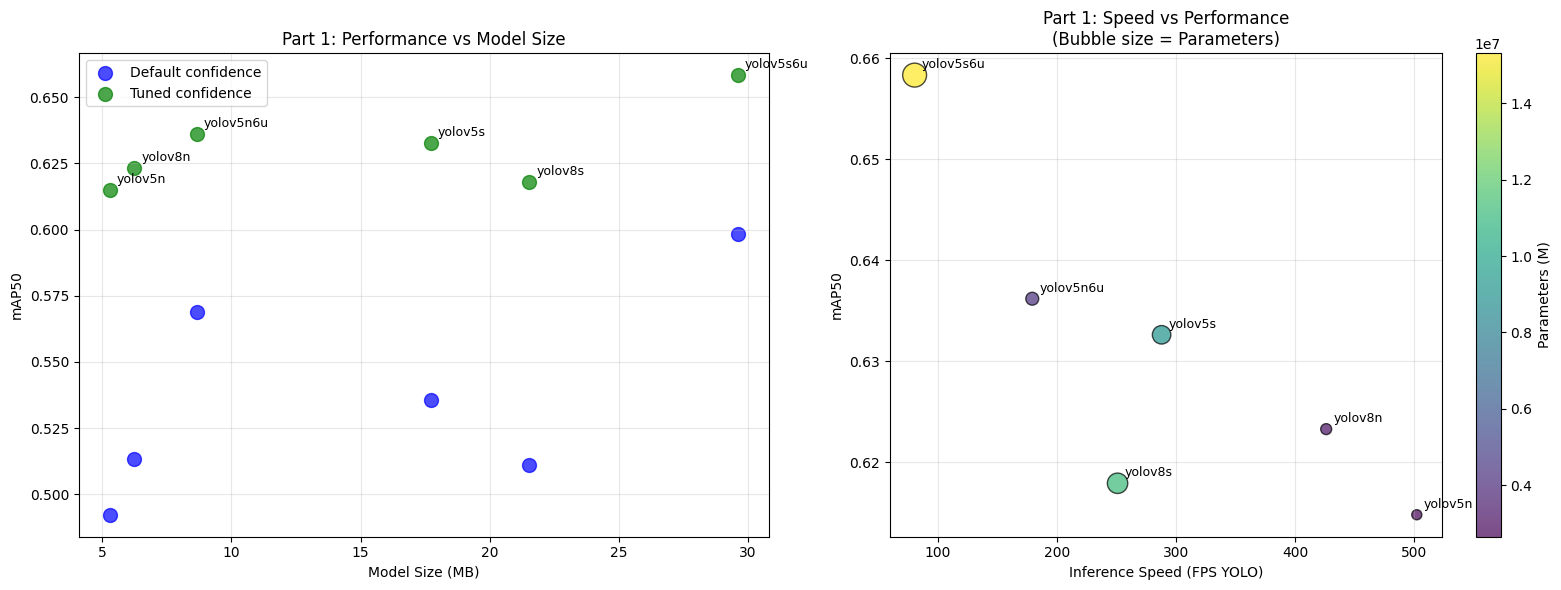

🔄 Updating repository...
✅ Uploaded part1_performance_comparison.png to GitHub
📊 Visualization saved to yolo_dataset_split/part1_performance_comparison.png


In [10]:
# Create visualizations for Part 1 results
if part1_results and len(part1_results) > 1:
    
    # Performance comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: mAP50 vs Model Size
    ax1.scatter(df_part1['size_mb'], df_part1['default_map50'], 
               s=100, alpha=0.7, color='blue', label='Default confidence')
    ax1.scatter(df_part1['size_mb'], df_part1['optimized_map50'], 
               s=100, alpha=0.7, color='green', label='Tuned confidence')
    
    for idx, row in df_part1.iterrows():
        ax1.annotate(row['model_name'], 
                    (row['size_mb'], row['optimized_map50']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, ha='left')
    
    ax1.set_xlabel('Model Size (MB)')
    ax1.set_ylabel('mAP50')
    ax1.set_title('Part 1: Performance vs Model Size')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: FPS vs mAP50
    bubble_sizes = [size * 10 for size in df_part1['size_mb']]  # Size based on MB
    scatter = ax2.scatter(df_part1['fps_yolo'], df_part1['optimized_map50'], 
                     s=bubble_sizes, alpha=0.7, 
                     c=df_part1['parameters'], cmap='viridis',  # Color by parameters
                     edgecolors='black', linewidth=1)
    
    for idx, row in df_part1.iterrows():
        ax2.annotate(row['model_name'], 
                    (row['fps_yolo'], row['optimized_map50']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, ha='left')
    
    ax2.set_xlabel('Inference Speed (FPS YOLO)')
    ax2.set_ylabel('mAP50')
    ax2.set_title('Part 1: Speed vs Performance\n(Bubble size = Parameters)')
    ax2.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=ax2, label='Parameters (M)')
    plt.tight_layout()
    
    # Save plot
    plot_path = Path(output_dir) / 'part1_performance_comparison.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Upload plot to GitHub
    if github_available:
        upload_to_github(plot_path, "Add Part 1 performance comparison plot")
    
    print(f"📊 Visualization saved to {plot_path}")

else:
    print("📊 Insufficient data for visualization")

## 8. Part 1 Summary and Next Steps

In [11]:
# Generate final Part 1 summary
print(f"\n🎯 PART 1 FINAL SUMMARY")
print("=" * 80)

if part1_results:
    print(f"📊 EXPERIMENT OVERVIEW:")
    print(f"   • Models evaluated: {len(part1_results)}")
    print(f"   • Model families: YOLOv5, YOLOv8")
    print(f"   • Training epochs: {TRAINING_PARAMS['epochs']}")
    print(f"   • Dataset: TACO-1 (single class litter)")
    
    if len(part1_results) > 0:
        best_model = df_part1.loc[df_part1['optimized_map50'].idxmax()]
        fastest_model = df_part1.loc[df_part1['fps_yolo'].idxmax()]
        smallest_model = df_part1.loc[df_part1['size_mb'].idxmin()]
        
        print(f"\n🏆 KEY FINDINGS:")
        print(f"   • Best performance: {best_model['model_name']} (mAP50: {best_model['optimized_map50']:.3f})")
        print(f"   • Fastest inference: {fastest_model['model_name']} ({fastest_model['fps_yolo']:.1f} FPS)")
        print(f"   • Smallest model: {smallest_model['model_name']} ({smallest_model['size_mb']:.1f} MB)")
        print(f"   • Average improvement: {df_part1['map50_improvement'].mean()*100:.1f}%")
    
    print(f"\n📁 FILES GENERATED:")
    output_files = list(Path(output_dir).glob('*'))
    for file in output_files:
        print(f"   • {file.name}")
    
    # Create summary for Part 2
    part1_summary = {
        'completed_models': len(part1_results),
        'failed_models': len(failed_models),
        'best_map50': df_part1['optimized_map50'].max() if len(part1_results) > 0 else 0,
        'results': part1_results,
        'completed_at': datetime.now().isoformat()
    }
    
    # Save summary for Part 2 to use
    summary_path = Path(output_dir) / 'part1_summary_for_part2.json'
    with open(summary_path, 'w') as f:
        json.dump(part1_summary, f, indent=2, default=str)
    
    if github_available:
        upload_to_github(summary_path, "Add Part 1 summary for Part 2 integration")
    
    print(f"\n📋 NEXT STEPS:")
    print(f"   1. Run Part 2 notebook for YOLOv9, v10, v11, v12")
    print(f"   2. Part 2 will automatically load Part 1 results")
    print(f"   3. Combined analysis will be generated in Part 2")
    print(f"   4. All results are saved to GitHub repository")

else:
    print(f"❌ No models completed successfully")
    print(f"   Failed models: {failed_models}")

print(f"\n✅ PART 1 COMPLETED SUCCESSFULLY")
print(f"   Ready to proceed with Part 2")
print("=" * 80)


🎯 PART 1 FINAL SUMMARY
📊 EXPERIMENT OVERVIEW:
   • Models evaluated: 6
   • Model families: YOLOv5, YOLOv8
   • Training epochs: 100
   • Dataset: TACO-1 (single class litter)

🏆 KEY FINDINGS:
   • Best performance: yolov5s6u (mAP50: 0.658)
   • Fastest inference: yolov5n (502.2 FPS)
   • Smallest model: yolov5n (5.3 MB)
   • Average improvement: 9.4%

📁 FILES GENERATED:
   • yolo_part1_final_results.csv
   • part1_intermediate_results_4.json
   • part1_intermediate_results_3.json
   • part1_intermediate_results_3.csv
   • part1_intermediate_results_2.csv
   • val
   • part1_intermediate_results_6.csv
   • part1_intermediate_results_5.json
   • test
   • part1_intermediate_results_5.csv
   • part1_performance_comparison.png
   • part1_intermediate_results_2.json
   • part1_intermediate_results_1.json
   • yolo_part1_final_results.json
   • data.yaml
   • train
   • part1_intermediate_results_6.json
   • part1_intermediate_results_4.csv
   • part1_intermediate_results_1.csv
🔄 Updating 

## 9. Cleanup and Final Upload

In [12]:
# Final cleanup and upload
print(f"🧹 Performing final cleanup and upload...")

# Create a final comprehensive report
final_report = {
    'experiment_info': {
        'part': 1,
        'models_targeted': list(PART1_YOLO_MODELS.keys()),
        'models_completed': [r['model_name'] for r in part1_results],
        'models_failed': failed_models,
        'start_time': datetime.fromtimestamp(start_time).isoformat(),
        'end_time': datetime.now().isoformat(),
        'total_time_hours': (time.time() - start_time) / 3600
    },
    'training_params': TRAINING_PARAMS,
    'augmentation_params': AUGMENTATION_PARAMS,
    'confidence_thresholds': CONFIDENCE_THRESHOLDS,
    'results': part1_results
}

# Save final report
report_path = Path(output_dir) / 'part1_final_report.json'
with open(report_path, 'w') as f:
    json.dump(final_report, f, indent=2, default=str)

# Upload final report
if github_available:
    upload_to_github(report_path, "Add Part 1 final comprehensive report")

print(f"📁 Final report saved: {report_path}")
print(f"🚀 Part 1 notebook execution complete!")
print(f"📊 Results available in GitHub repository")
print(f"➡️  Ready for Part 2 execution")

🧹 Performing final cleanup and upload...
🔄 Updating repository...
✅ Uploaded part1_final_report.json to GitHub
📁 Final report saved: yolo_dataset_split/part1_final_report.json
🚀 Part 1 notebook execution complete!
📊 Results available in GitHub repository
➡️  Ready for Part 2 execution
